# TP d'OCVX : démélange spectral par moindres carrés et régularisation 

**/!\** Avant de débuter le TP, vous devez avoir lu la petite introduction sur le démélange spectral. Les notations sont les mêmes que dans le document, et les termes spécifiques ne sont pas réintroduits ici.

L'objectif de ce TP est de vous faire manipuler la résolution d'un problème concret (en l'occurrence, le démélange spectral) par méthode des moindres carrés ordinaires, et de vous montrer ce qu'il est possible de faire lorsque le problème est mal posé via les méthodes de régularisation classiques.

Pour le moment, nous n'avons pas le bagage théorique nécessaire à résolution complète du problème de démélange spectral, c'est à dire en intégrant les contraintes de positivité et de somme à 1 pour les abondances. Mais le démélange n'est ici qu'un prétexte, on prendra juste garde à ne pas chercher à interpréter les résultats obtenus pour les abondances en termes de proportions (sauf si vous arrivez à obtenir des abondances positives et sommant à 1 uniquement avec les méthodes abordées dans ce TP, auquel cas, on écrira directement une publication$\dots$)

## I. Introduction

In [1]:
# Les imports de base
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy as sp
from scipy import spatial
import skimage
from skimage import exposure

from sklearn.metrics import confusion_matrix, classification_report
from matplotlib.colors import LogNorm
import pandas as pd
import seaborn as sn
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso as Lasso_sk

On commence par importer les données (hsi $=$ *hyperspectral image*), et une vérité terrain (*gt $=$ ground truth*) normalement utilisée pour de la classification (mais elle va nous permettre de générer la matrice d'endmembers $\mathbf{E}$ à moindres frais).

Les données sont de suite normalisées entre 0 et 1 (correspondant à peu près à une conversion radiance $\Rightarrow$ réflectance).

In [2]:
hsi = np.load('data/pavia.npy')
gt = np.load('data/groundtruth.npy')
hsi = hsi/hsi.max() # conversion de la réflectance en radiance
Nrow,Ncol,Nbands = hsi.shape # sera utile plus tard pour les conversions tenseur 3D/matrice
Npix = Nrow*Ncol
print(hsi.shape)

(610, 340, 103)


On vérifie tout de suite les dimensions de l'image : $610$ lignes, $340$ colonnes et $103$ bandes spectrales.


Quelques infos : la scène a été acquise au dessus de l'université de Pavie, en Italie, par le capteur ROSIS 03 (*Reflective Optics System Imaging Spectrometer*). La résolution spatiale du capteur est de $2.6$ m (autrement dit, un pixel couvre une zone de $2.6 \times 2.6$ m au sol). Les $103$ bandes spectrales s'étalent de $430$ nm à $860$ nm, avec une largeur de bande de $4.0$ nm.

Pour visualiser cette image, il va tout d'abord falloir en extraire une image RGB, donc sélectionner un canal de rouge, un canal de vert et un canal de bleu parmi les $103$ bandes spectrales. Pour ce jeu de données, on utiliser en général $R = 47$, $G = 26$ et $B = 10$.

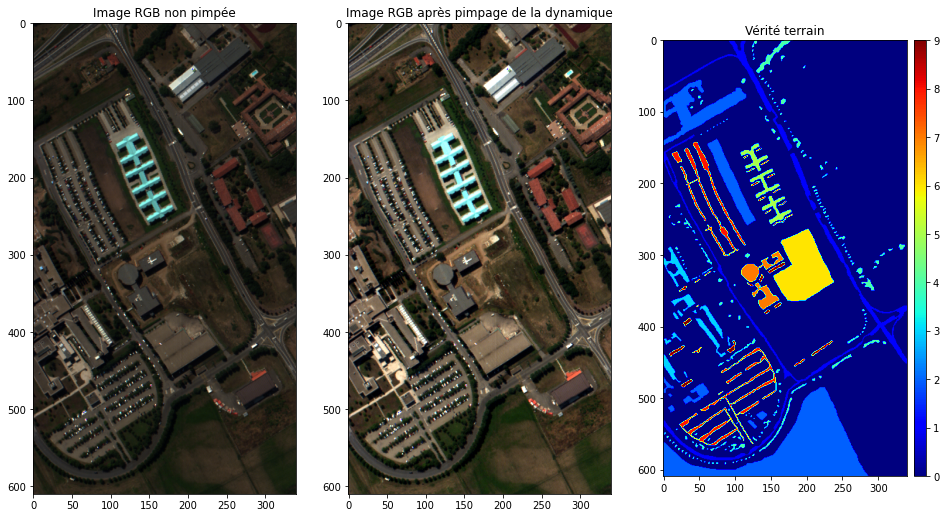

In [3]:
# Par convention, les bandes RGB de cette image sont R=47, G=26 et B=10
hsi_rgb = hsi[:,:,[47,26,10]]

# Réétalonne la dynamique de l'histogramme de chaque bande RGB (étire l'histogramme comprit entre 1% et 99%)
perc = 1
plow, phigh = np.percentile(hsi_rgb, (perc, 100-perc))
pimp_my_hsi_rgb = exposure.rescale_intensity(hsi_rgb, in_range=(plow, phigh))

# Affiche tout ce bazar
plt.figure(figsize=(16,16))
plt.subplot(131)
plt.title('Image RGB non pimpée')
plt.imshow(hsi_rgb)
plt.subplot(132)
plt.imshow(pimp_my_hsi_rgb)
plt.title('Image RGB après pimpage de la dynamique')
plt.subplot(133)
ax = plt.gca()
plt.title('Vérité terrain')
imgt = ax.imshow(gt,cmap='jet')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(imgt, cax=cax)
plt.show()

Pour la vérité terrain ci-dessus, chacune des 9 classes présentent dans l'image est identifiée par un label allant de $1$ à $9$ (la classe $0£ étant, par convention, le fond de l'image). La correspondance des labels avec leur classe sémantique est donné ci-dessous

| label | classe |
|  ---  |   ---  | 
| 1 | Asphalte |
| 2 | Champ/herbe |
| 3 | Gravier |
| 4 | Végétation |
| 5 | Plaques de métal peintes |
| 6 | Sol nu|
| 7 | Bitume |
| 8 | Briques autobloquantes |
| 9 | Ombre |

Plutôt que d'utiliser un algorithme d'induction aveugle d'endmembers ou une bibliothèque spectrale, on va se servir de la vérité terrain pour construire la matrice d'endmembers $\mathbf{E}$.

On va cependant exclure la classe "ombre", qui ne peut pas être considéré comme un constituant macroscopique pur. Pour les classes de $1$ à $8$, on va définir la signature spectral de l'endmember correspondant comme étant le médoïde de tous les pixels appartenant à la classe.

AttributeError: 'AxesSubplot' object has no attribute 'bar_label'

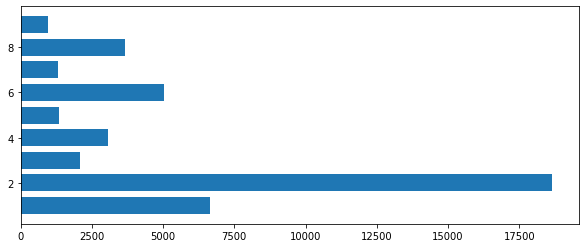

In [4]:
fig, axs = plt.subplots(figsize=(10, 4))

bar_x, bar_count = np.unique(gt[gt != 0], return_counts=True)
bar = axs.barh(bar_x, bar_count, 0.75)

axs.bar_label(bar)

axs.set_yticks(np.arange(len(bar_x)) + 1)
axs.invert_yaxis() 

axs.set_title('Histogram ground truth')
plt.show()

Pour mieux connaitre la répartition des nos classes, nous avons décidé d'afficher l'histogramme correspondant. Nous pouvons remarquer que la classe 2 est la plus présente.

**1.1) Quelle est la différence principale entre le centroïde et le médoïde d'un ensemble de points ? Quel est le principal avantage du médoïde par rapport au centroïde ?**

Les médoïdes sont des points du jeu de données alors que les centroïdes sont des points estimés (centre de gravité).

Les médoïdes sont plus robustes au bruit et aux anomalies statistiques.

L'algorithme de calcul du médoïde d'un ensemble de points est donné ci-dessous (il n'est pas nécessaire d'essayer de le comprendre)

In [5]:
# vecteur médoïde xmed de X [Nsamples,Nfeatures]
# (pompé sans aucune honte quelque part sur le net)
def geometric_median(X, eps=1e-5):
    y = np.mean(X, 0)

    while True:
        D = sp.spatial.distance.cdist(X, [y])
        nonzeros = (D != 0)[:, 0]

        Dinv = 1 / D[nonzeros]
        Dinvs = np.sum(Dinv)
        W = Dinv / Dinvs
        T = np.sum(W * X[nonzeros], 0)

        num_zeros = len(X) - np.sum(nonzeros)
        if num_zeros == 0:
            y1 = T
        elif num_zeros == len(X):
            return y
        else:
            R = (T - y) * Dinvs
            r = np.linalg.norm(R)
            rinv = 0 if r == 0 else num_zeros/r
            y1 = max(0, 1-rinv)*T + min(1, rinv)*y

        if sp.spatial.distance.euclidean(y, y1) < eps:
            return y1

        y = y1

On peut donc constituer la matrice d'endmembers $\mathbf{E} \in \mathbb{R}^{N_{bands} \times m}$, en récupérant le médoïde de chacune des $m=8$ premières classes de la vérité terrain. $N_{bands}$ étant évidemment le nombre de bandes dans l'image hyperspectrale

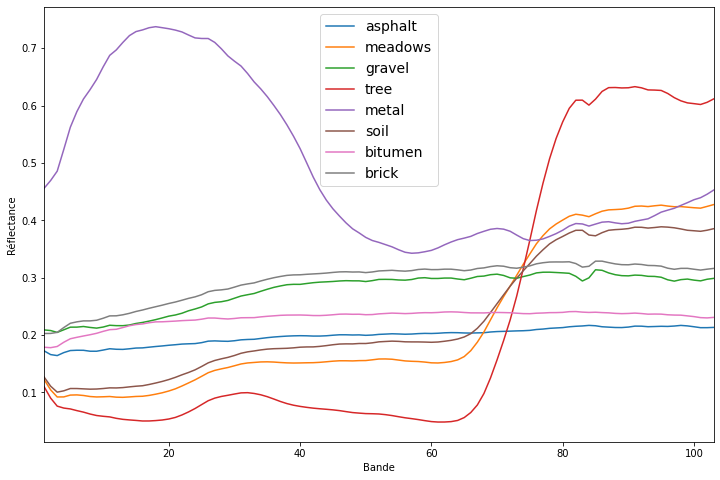

In [6]:
# liste des noms des constituants macroscopiques
endmembers = ['asphalt','meadows','gravel','tree','metal','soil','bitumen','brick']
# m => nombre total d'endmembers considérés
m = len(endmembers)
# E => matrice Nbands x m
E = np.zeros((Nbands,m))
# vectorisation du cube 3D (Nrow x Ncol x Nbands) en matrice (Npix x Nbands)
hsir = hsi.reshape(Npix,Nbands)
# extraction du médoïde pour chaque classe
for c in range(1,m+1): # indice des classes commençant à 1
    class_idx = (gt==c).ravel() # indices vectorisé des pixels appartenant à la classe c
    all_spectra = hsir[class_idx,:] # récupération des spectres correspondants (lignes de la matrice hsir)
    E[:,c-1] = geometric_median(all_spectra) # calcul du médoïde et stockage dans E
    
# On affice les signatures spectrales des 8 endmembers
plt.figure(figsize=(12,8))
for m,em in enumerate(endmembers):
    plt.plot(np.arange(1,104),E[:,m],label=em)
plt.xlim((1,103))
plt.xlabel('Bande')
plt.ylabel('Réflectance')
plt.legend(loc='best',fontsize=14)
plt.show()

## II. Démélange par moindres carrés ordinaires

On attaque maintenant le vif du sujet. Étant donnés la matrice d'endmembers $\mathbf{E} = [\mathbf{e}_1,\dots,\mathbf{e}_m] \in \mathbb{R}^{N_{bands} \times m}$ et le spectre $\mathbf{x} \in \mathbb{R}^{N_{bands}}$ d'un pixel, on veut récupérer les abondances fractionnelles $\boldsymbol \phi = [\phi_1,\dots,\phi_m]$ de $\mathbf{x}$.

D'après le LMM, $\mathbf{x}$ s'écrit comme la combinaison linéaire des endmembers $\mathbf{e}_i$ pondérés par leur abondance fractionnelle $\phi_i$ correspondante (plus un bruit additif indépendant pour modéliser les imprefections du modèle) :
$$ \mathbf{x} = \sum_{i=1}^m \phi_i \mathbf{e}_i + \boldsymbol \eta = \mathbf{E} \boldsymbol \phi + \eta$$

L'inversion de ce modèle revient à calculer le vecteur $\boldsymbol \phi$ qui minimise la _residual sum of squares_ $RSS(\boldsymbol \phi) = \displaystyle \sum_{i=1}^{N_{bands}} \big(x(i) - [\mathbf{E}\boldsymbol \phi](i)\big)^2 = \|\mathbf{x} -  \mathbf{E}\boldsymbol \phi \|_2^2$ :

$$ \boldsymbol \phi = \arg\min_{\boldsymbol \phi \in \mathbb{R}^m} = \|\mathbf{x} -  \mathbf{E}\boldsymbol \phi \|_2^2 \quad (1)$$

**2.1) Retrouver analytiquement la solution du problème (1).**

Il s'agira d'exprimer $\boldsymbol \phi$ en fonction de $\mathbf{E}$ et $\mathbf{x}$.

Vous devez coder la solution analytique vous même dans un premier temps. Ce n'est que dans un second temps que vous pourrez vous rassurer (ou pas) en vérifiant que vous obtenez bien la même chose qu'un solveur de moindres carrés ordinaires.

Démélangez dans un premier temps des spectres appartenant à l'une des 8 classes.

On pose $f(\phi) = RSS(\phi) = \lVert x-E\phi \rVert_2^2$.\
Pour minimiser $f$, on cherche à résoudre $\nabla(f) = \vec{0}$.\
\begin{align*}
    f(\phi) &= \lVert x - E\phi \rVert_2^2\\
    &= (x-E\phi)^T(x-E\phi)\\
    &= x^Tx - x^TE\phi - \phi^TE^Tx + \phi^TE^TE\phi
\end{align*}

* $g(\phi) = x^TE\phi$\
$g(\phi + h) = x^TE\phi + x^TEh$\
On obtient $\nabla(g)^T = x^TE = (E^Tx)^T$\
Donc $\nabla(g) = E^Tx$

    
* $g(\phi) = \phi^TE^T\phi$\
$g(\phi + h) = (\phi+h)^TE^Tx = \phi^TE^Tx+h^TE^Tx$\
On obtient $\nabla(g) = E^Tx$


* $g(\phi) = \phi^TE^TE\phi$\
$g(\phi+h) = \phi^TE^TE\phi + \phi^TE^TEh + h^TE^TE\phi + h^TE^TEh$\
On obtient $\nabla(g) = E^TE\phi + (\phi^TE^TE)^T = 2E^TE\phi$

On réinjecte dans $\nabla(f) = \vec{0}$ pour retrouver l'équation normale.
\begin{align*}
    \nabla(f) = \vec{0} \quad &\iff \quad -E^Tx - E^Tx + 2E^TE\phi = 0\\
    &\iff \quad E^TE\phi = E^Tx\\
    &\iff \quad \phi = (E^TE)^{-1}E^Tx
\end{align*}

In [7]:
def analytic_solution(E, x):
    return np.linalg.inv(E.T @ E) @ E.T @ x

**2.2) En théorie, quelle devrait être la composition du vecteur d'abondances $\boldsymbol \phi$? Et qu'en est-il en pratique ? Comparez graphiquement le spectre initial $\mathbf{x}$ avec sa reconstruction $\hat{\mathbf{x}} = \mathbf{E}\boldsymbol \phi$**

En théorie, $\boldsymbol \phi$ devrait être composée de valeurs comprises entre 0 et 1 pour chaque pixel et chaque endmember, car ce sont des probabilités. Par conséquent, pour chaque pixel, la somme des éléments de $\boldsymbol \phi$ devrait être égale à 1.

En pratique, ce n'est pas le cas, car dans notre modèle nous n'avons pas appliqué de contraintes.

In [8]:
gt_flatten = gt.flatten()

In [9]:
# Get 0 and 0 classes indexes
usefull_idx = np.where((gt_flatten != 0) & (gt_flatten != 9))[0]

In [10]:
# Remove 0 and 9 classes
hsi_usefull = hsi.reshape((-1, 103))[usefull_idx]
gt_usefull = gt_flatten[usefull_idx]

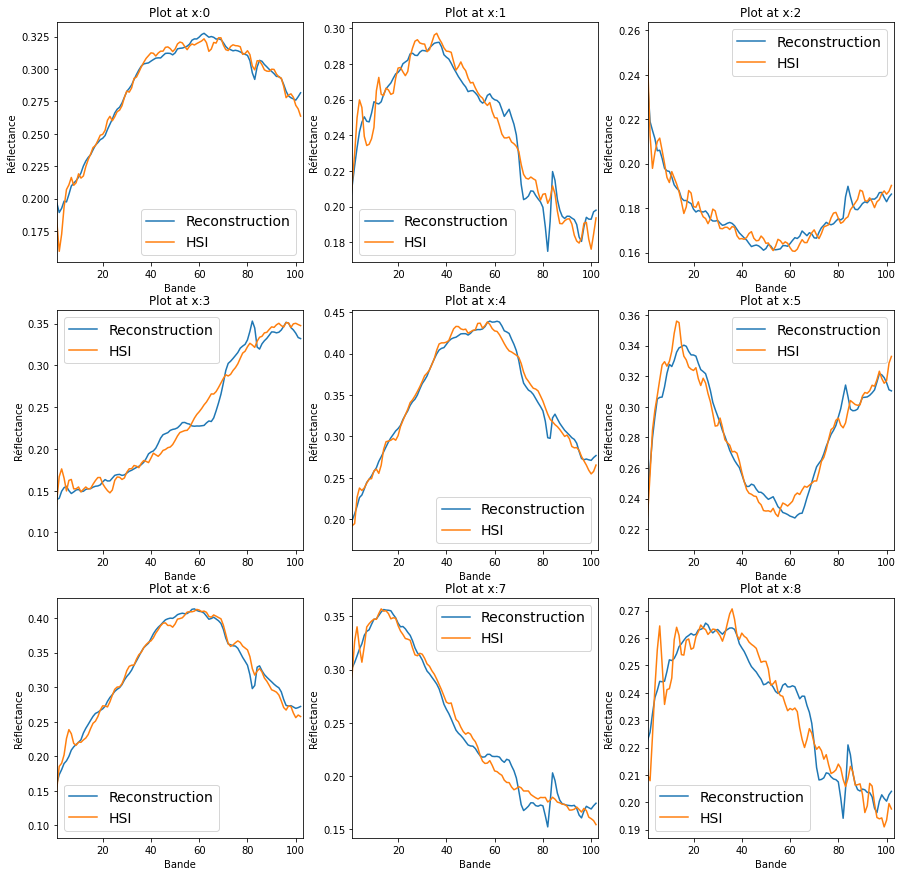

In [11]:
plt.figure(figsize=(15,15))

for i in range(9):
    x = hsi_usefull[i]
    x_hat = E @ analytic_solution(E, x)
    
    plt.subplot(3, 3, i + 1)
    plt.plot(x_hat, label='Reconstruction')
    plt.plot(x, label='HSI')
    plt.title("Plot at x:{}".format(i))
    plt.xlim((1,103))
    plt.xlabel('Bande')
    plt.ylabel('Réflectance')
    plt.legend(loc='best',fontsize=14)
plt.show()

On peut constater que les deux courbes sont très proches et l'écart entre les deux est faible. On peut donc noter que notre estimation est plutôt bonne et les données sont bien reconstruites.

Il est coutûme de mesurer quantitativement la qualité de démélange de $\mathbf{x}$ par l'erreur quadratique moyenne entre $\mathbf{x}$ et sa reconstruction $\mathbf{\hat{x}} = \sum_{i=1}^m \phi_i \mathbf{e}_i$ :

$$\epsilon(\mathbf{x},\mathbf{\hat{x}}) = \sqrt{\frac{1}{N_{bands}} \sum_{i=1}^{N_{bands}} (x(i) - \hat{x}(i))^2} \quad (2)$$

**2.3) Implémentez la fonction d'erreur quadratique moyenne. Quel ordre de grandeur obtenez vous pour les spectres démélangées précédemment ?**

In [12]:
def mean_square_error(x, x_hat):
    s_diff = (x - x_hat) ** 2
    if len(x.shape) == 1:
        return np.sqrt(np.mean(s_diff))
    else:
        return np.sqrt(np.mean(s_diff, axis=1))

In [13]:
# Compute MSE for first 9 values
for i in range(9):
    x = hsi_usefull[i]
    x_hat = E @ analytic_solution(E, x)
    print("MSE at ({}): {}".format(i, mean_square_error(x, x_hat)))

MSE at (0): 0.007252513995219748
MSE at (1): 0.008593854097406572
MSE at (2): 0.0041884279167854225
MSE at (3): 0.014517409523267775
MSE at (4): 0.009407425444369951
MSE at (5): 0.00919077474345841
MSE at (6): 0.010806094051795896
MSE at (7): 0.010248537061416091
MSE at (8): 0.0075451691288880695


On peut constater que pour les premières valeurs nous obtenons une erreur quadratique moyenne d'au plus 0.015 ce qui est assez faible. Cependant, il serait plus judicieux de calculer la moyenne des erreurs quadratiques.

In [14]:
# Compute MSE for all values
mses = np.empty((hsi_usefull.shape[0]))
for i in range(hsi_usefull.shape[0]):
    x = hsi_usefull[i]
    x_hat = E @ analytic_solution(E, x)
    mses[i] = mean_square_error(x, x_hat)
        
mses.mean() # Moyenne des erreurs quadratiques moyennes de tous les pixels de l'image

0.006456906105144761

En calculant la moyenne des erreurs, nous obtenons 0.0065.

L'ordre de grandeur des erreurs est au centième près. Notre modèle est plutôt bon sur les données d'entrainements. 

Démélanger pixel par pixel, c'est bien. Mais s'il était possible d'obtenir d'un coup les abondances fractionnelles de tous les pixels de l'image, ça serait vachement mieux. Et ça tombe bien, car c'est possible : il suffit d'utiliser la modélisation matricielle de l'image hyperspectrale $\mathbf{X} \in \mathbb{R}^{N_{bands} \times N_{pix}}$ et d'étendre le problème (1) sous la forme 

$$\boldsymbol \Phi = \arg\min_{\Phi \in \mathbb{R}^{m\times N_{pix}}} = \|\mathbf{X} -  \mathbf{E}\Phi \|_2^2 \quad (1)$$

La solution $\boldsymbol \Phi \in \mathbb{R}^{m\times N_{pix}}$ obtenue s'interprète donc comme une matrice d'abondances fractionnelles, où chaque colonne contient le vecteur d'abondance $\boldsymbol \phi$ du pixel correspondant. Cette matrice peut se réorganiser à moindres frais en un cube 3D $(N_{row} \times N_{col} \times m)$, où chaque canal peut se visualiser comme la carte d'abondances fractionelles de l'image entière pour l'endmember considéré.

**2.4) Adaptez votre implémentation de la question 2) pour obtenir la matrice d'abondance $\boldsymbol \Phi$ en un coup**

In [15]:
phi = analytic_solution(E, hsi_usefull.T)
x_hat = E @ phi

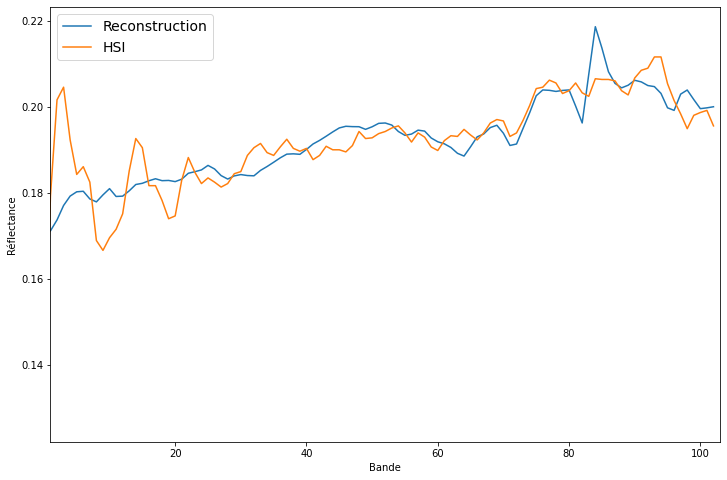

In [16]:
plt.figure(figsize=(12,8))
plt.plot(x_hat[:, 12], label='Reconstruction')
plt.plot(hsi_usefull[12, :], label='HSI')
plt.xlim((1,103))
plt.xlabel('Bande')
plt.ylabel('Réflectance')
plt.legend(loc='best',fontsize=14)
plt.show()

**2.5) Réorganisez la matrice précédente en un cube 3D et visualisez les différentes cartes d'abondances pour les 8 endmembers. Que remarquez vous/pouvez vous en conclure ?**

In [17]:
# Build entire phi
full_phi = np.zeros((Nrow * Ncol, 8))
full_phi[usefull_idx] = phi.T
full_phi = full_phi.reshape((Nrow, Ncol, 8))

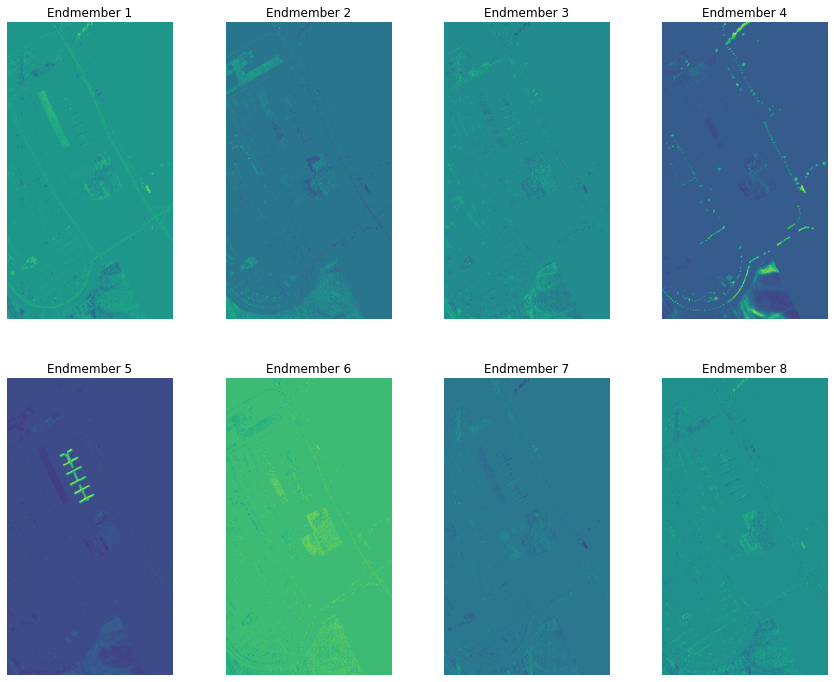

In [18]:
# Display abondance map for each endmembers
plt.figure(figsize=(15,12))

for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.title('Endmember {}'.format(i + 1))
    plt.imshow(full_phi[:, :, i])
    plt.axis('off')
    
plt.show()

Nous pouvons remarquer que les differentes cartes d'abondances apportent des informations differentes sur l'image. Par exemple, sur la carte d'abondance numero 5 on observe un motif que l'on ne retrouve pas sur les autres cartes, à savoir un motif qui correspond aux plaques de métales peintes. 

Tout comme l'équation (1) peut se reformuler pour obtenir une solution matricielle (la matrice $\boldsymbol \Phi$), il est possible d'obtenir d'un coup l'erreur quadratique moyenne de l'image entière $\epsilon(\mathbf{X},\mathbf{\hat{X}} = \mathbf{E}\boldsymbol \Phi)$ (plutôt que de boucler sur tous les pixels).

**2.6) Visualisez la carte d'erreur quadratique moyenne de l'image hyperspectral pour le démélange obtenu**

In [19]:
x_hat = E @ analytic_solution(E, hsi_usefull.T)
mses = mean_square_error(hsi_usefull, x_hat.T)

In [20]:
# Build image from errors
full_mses = np.zeros((Nrow * Ncol))
full_mses[usefull_idx] = mses
full_mses = full_mses.reshape((Nrow, Ncol))

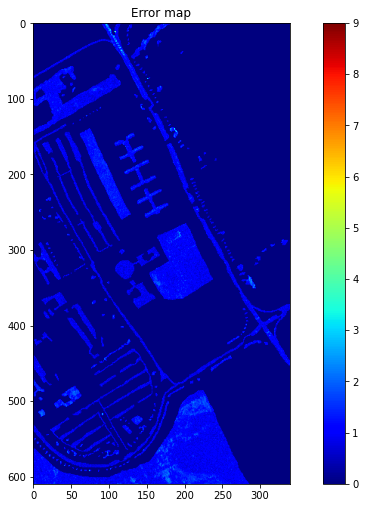

In [21]:
plt.figure(figsize=(12, 8))
plt.imshow(full_mses, cmap='jet')
plt.title('Error map')
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.65, 0.1, 0.025, 0.8])
plt.colorbar(imgt, cax=cax)
plt.show()

Ci-dessus, nous avons affiché la carte d'erreurs et nous pouvons constater que l'erreur commise est très faible. En effet, tous les pixels apparaissent bleus. Nous pouvons également afficher les valeurs minimales et maximales de nos erreurs.

In [22]:
print('Min error: {}'.format(mses.min()))
print('Max error: {}'.format(mses.max()))

Min error: 0.0024639649518658317
Max error: 0.0540473829203088


On peut imaginer une stratégie de classification naïve : chaque pixel est classifié selon son abondance fractionnelle majoritaire (puisqu'en théorie, plus l'abondance fractionelle est proche de $1$, plus le matériau correspondant est présent dans la signature spectrale du pixel en question). Même si le démélange obtenu précédemment avec les moindres carrés ordinaires devrait laisser à penser que cette stratégie est vouée à l'échec, on peut quand même y jeter un oeil.

Elle pourrait avoir particulièrement du sens pour les pixels supposés "purs", c'est à dire tous les pixels de la vérité terrain dont le label est compris entre $1$ et $8$ (les pixels labelisés $0$ sont de classe inconnue du point de vue de la classification, et les pixels labelisés $9$ correspondant à de l'ombre (d'un autre matériau), ils ne sont pas purs non plus).

**2.7) Appliquez la stratégie de classification évoquée juste au dessus, à savoir que chaque pixel est classifié selon son abondance fractionnelle majoritaire, et visualisez la carte de classification obtenue. Que pouvez vous en conclure ?**

In [23]:
classifier = np.argmax(phi, axis=0) + 1

# Build image with the strategy
full_classifier = np.zeros((Nrow * Ncol))
full_classifier[usefull_idx] = classifier
full_classifier = full_classifier.reshape((Nrow, Ncol))

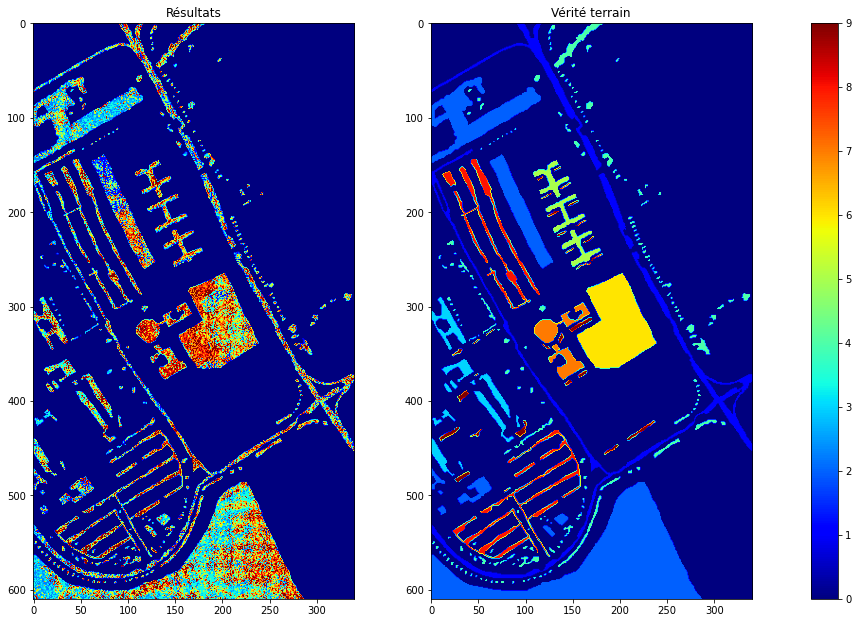

In [24]:
plt.figure(figsize=(15, 10))

plt.subplot(1, 2, 1)
plt.imshow(full_classifier, cmap='jet')
plt.title('Résultats')

plt.subplot(1, 2, 2)
plt.imshow(gt, cmap='jet')
plt.title('Vérité terrain')

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.85, 0.1, 0.025, 0.8])
plt.colorbar(imgt, cax=cax)

plt.show()

On cherche à résoudre un problème qui nécessite d'avoir des contraintes pour que le modèle fonctionne correctement. Cependant, on ne les considère pas pour le moment, ce qui nous amène à un résultat décevant.

L'évaluation qualitative précédente permet de donner des billes sur ce qui marche et ce qui ne marche pas à propos de la stratégie de classification appliquée. Mais cette évaluation qualitative doit être complétée par une évaluation quantitative plus rigoureuse, par le biais des métriques classiques de classification que vous connaissez.

**2.8) Complétez votre analyse précédente par une évaluation quantitative : taux de bonne classification globale, matrice de confusion et taux de bonne classification par classe**

In [25]:
def plot_confusion_matrix(labels, preds, class_names, title='Confusion matrix', log=False):
    '''
    Plot the confusion matrix
    params
    ----------
    labels: Labels array of shape (n_samples,)
    preds: Predictions array of shape (n_samples,)
    class_names: Names of the different classes
    title: Title of the plot
    log: Logarithm plot
    '''
    # Plot confusion matrix using log / linear scale

    # Get confusion matrix and skip background (label 0)
    matrix = confusion_matrix(labels.flatten(), preds.flatten())

    df = pd.DataFrame({class_names[i]:matrix[:,i] for i in range(len(class_names))}, index=class_names)
    fig = plt.figure(figsize = (10,6))
    ax = fig.add_subplot()
    ax.xaxis.set_ticks_position('top')
    if log:
        sn.heatmap(df, annot=True, cmap="OrRd", fmt='g', norm=LogNorm())
    else:
        sn.heatmap(df, annot=True, cmap="OrRd", fmt='g')

    plt.title(title)
    plt.show()

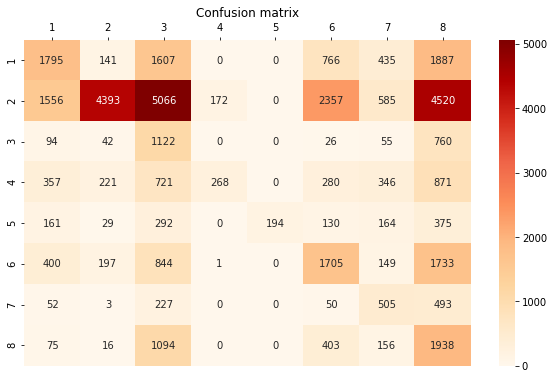

In [26]:
plot_confusion_matrix(gt_usefull, full_classifier[full_classifier != 0], class_names=np.arange(1, 9), log=False)

Nous pouvons remarquer que la diagonale de la matrice n'est pas mise en avant. Cela signifie que notre classification commet de nombreuses erreurs. 

In [27]:
print(classification_report(gt_usefull, full_classifier[full_classifier != 0]))

              precision    recall  f1-score   support

           1       0.40      0.27      0.32      6631
           2       0.87      0.24      0.37     18649
           3       0.10      0.53      0.17      2099
           4       0.61      0.09      0.15      3064
           5       1.00      0.14      0.25      1345
           6       0.30      0.34      0.32      5029
           7       0.21      0.38      0.27      1330
           8       0.15      0.53      0.24      3682

    accuracy                           0.28     41829
   macro avg       0.46      0.31      0.26     41829
weighted avg       0.59      0.28      0.31     41829



Nous avons décidé d'afficher le rapport de classification afin de pouvoir analyser les métriques pour chaque classe.

Nous pouvons remarquer que la precision de la classe 5 est de 1.0 mais le recall et le f1-score de cette même classe sont faibles ce qui signifie qu'il y a beaucoup de faux négatifs.

La précision (accuracy) moyenne de notre classification est seulement de 0.28 d'où le fait que nos résultats sont décevants.

## III. Régularisation de Tikhonov

Les techniques de régularisation sont très souvent utilisés pour la résolution de problèmes mal posés. Pour des problèmes linéaires sur-déterminés, c'est à dire du type $\mathbf{A}\mathbf{x} = \mathbf{b}$, où la matrice $\mathbf{A}$ possède plus de lignes que de colonnes - c'est notre cas ici - la régularisation va se matérialiser comme l'ajout d'un second terme $\mathcal{R}(\mathbf{x})$ au $RSS(\mathbf{x}) = \| \mathbf{A}\mathbf{x} - \mathbf{b}\|_2^2 $ :

$$ RSS \text{ avec régularisation : }  \| \mathbf{A}\mathbf{x} - \mathbf{b}\|_2^2 + \mathcal{R}(\mathbf{x}), \quad (3)$$

de manière à ce que la solution de ce problème d'optimisation retrouver des propriétés souhaitables (de stabilité par exemple, c'est-à-dire qu'une légère perturbation de l'entrée n'entraine qu'une légère perturbation de la sortie, ce qui n'est pas le cas sans régularisation si $\mathbf{A}$ est mal conditionnée.

Le choix du terme de régularisation $\mathcal{R}(\mathbf{x})$ va bien sûr influer sur ces propriétés et sur la manière de résoudre le problème (3).

Dans le cas de la régularisation de Tikhonov, le terme de régularisation (aussi appelé _pénalité_) s'exprime comme $\mathcal{R}(\mathbf{x}) = \lambda \| \boldsymbol \Gamma \mathbf{x}\|_2^2$, où $\boldsymbol \Gamma$ (appelé matrice de Tikhonov) est déterminé en fonction du problème, et où $\lambda$ permet de donner plus où moins de poids à la régularisation par rapport au RSS.

Dans notre cas de démélange, $\boldsymbol \Gamma$ sera choisi comme la matrice identité, de manière à ce qu'on puisse réécrire le problème d'optimisation (en reprenant nos notations précédentes) : 

$$ \arg\min_{\boldsymbol \phi \in \mathbb{R}^m} = \|\mathbf{x} -  \mathbf{E}\boldsymbol \phi \|_2^2 + \lambda \|\boldsymbol \phi \|_2^2\quad (4)$$

Ainsi, le terme de régularisation, en pénalisant les solutions ayant des composantes importantes (en valeur absolue), aura tendance à privilégier des solutions $\boldsymbol \phi$ dont la norme euclidienne est faible. La valeure de $\lambda$ permettra de jouer sur le degré de régularisation (et donc la liberté qu'aura $\boldsymbol \phi$ d'avoir des entrées de magnitude élevée) : plus $\lambda$ sera élevé, et plus la régularisation sera importante.

Sans surprise, le but de cette partie va être d'étudier l'influence de la régularisation de Tikhonov sur le problème d'estimation des abondances, et la comparaison avec la méthode des moindres carrés ordinaires. IL s'agira donc ici de reproduire ce qui a été fait dans la partie II, tout en intégrant l'étude de l'influence de $\lambda$ sur la qualité du démélange

**3.1) Dérivez sur papier la solution analytique du problème (4)** (car oui, elle existe, et elle est pas tellement plus compliquée que la solution des moindres carrés ordinaires)

On pose $f(\phi) = RSS(\phi) = \lVert x-E\phi \rVert_2^2 + \lambda \left \| \phi \right \|_{2}^{2}$.\
Pour minimiser $f$, on cherche à résoudre $\nabla(f) = \vec{0}$.\
\begin{align*}
    f(\phi) &= \lVert x - E\phi \rVert_2^2 + \lambda \left \| \phi \right \|_{2}^{2}\\
    &= (x-E\phi)^T(x-E\phi) + \lambda \phi^T\phi\\
    &= x^Tx - x^TE\phi - \phi^TE^Tx + \phi^TE^TE\phi + \lambda \phi^T\phi
\end{align*}

* $g(\phi) = x^TE\phi$\
$g(\phi + h) = x^TE\phi + x^TEh$\
On obtient $\nabla(g)^T = x^TE = (E^Tx)^T$\
Donc $\nabla(g) = E^Tx$

    
* $g(\phi) = \phi^TE^T\phi$\
$g(\phi + h) = (\phi+h)^TE^Tx = \phi^TE^Tx+h^TE^Tx$\
On obtient $\nabla(g) = E^Tx$


* $g(\phi) = \phi^TE^TE\phi$\
$g(\phi+h) = \phi^TE^TE\phi + \phi^TE^TEh + h^TE^TE\phi + h^TE^TEh$\
On obtient $\nabla(g) = E^TE\phi + (\phi^TE^TE)^T = 2E^TE\phi$


* $g(\phi) = \lambda \phi^T\phi$\
$g(\phi + h) = \lambda (\phi + h)^T(\phi + h)$\
$g(\phi + h) = \lambda \phi^T\phi + \lambda 2 \phi^Th + \lambda h^T h$\
On obtient $\nabla(g) = \lambda 2 \phi$

On réinjecte dans $\nabla(f) = \vec{0}$ pour retrouver l'équation normale.
\begin{align*}
    \nabla(f) = \vec{0} \quad &\iff \quad -E^Tx - E^Tx + 2E^TE\phi + \lambda 2 \phi = 0\\
    &\iff \quad (E^TE + \lambda I)\phi = E^Tx\\
    &\iff \quad \phi = (E^TE + \lambda I)^{-1}E^Tx
\end{align*}

In [28]:
def analytic_solution_tikhonov(E, x, l):
    return np.linalg.inv(E.T @ E + l * np.identity(E.shape[1])) @ E.T @ x

**3.2) Implémentez le démélange avec régularisation de Tikhonov pour quelques spectres de l'image. Que remarquez vous qualitativement (comparaison de la signature originelle $\mathbf{x}$ avec la signature reconstruite) et quantitativement (valeur de l'erreur quadratique moyenne) par rapport aux solutions obtenues par moindres carrés ordinaires ? L'influence de $\lambda$ est elle bien conforme à celle prédite par la théorie ?**

In [29]:
x_moindres = E @ analytic_solution(E, hsi_usefull.T)
x_tikhonov = E @ analytic_solution_tikhonov(E, hsi_usefull.T, 0.008)

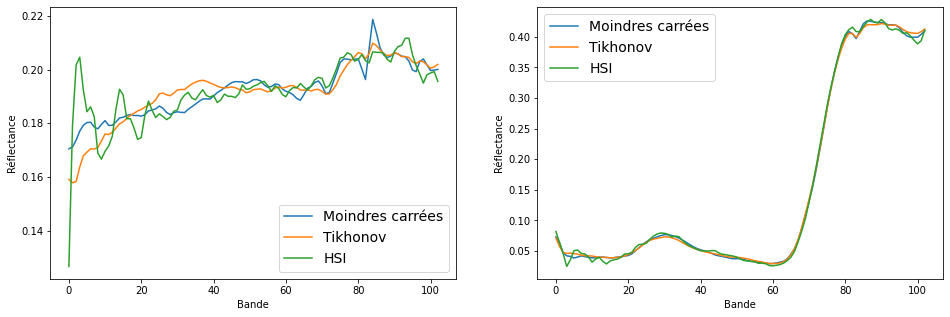

In [30]:
plt.figure(figsize=(16,5))

plt.subplot(1, 2, 1)
plt.plot(x_moindres[:, 12], label='Moindres carrées')
plt.plot(x_tikhonov[:, 12], label='Tikhonov')
plt.plot(hsi_usefull[12, :], label='HSI')
plt.xlabel('Bande')
plt.ylabel('Réflectance')
plt.legend(loc='best',fontsize=14)

plt.subplot(1, 2, 2)
plt.plot(x_moindres[:, 24], label='Moindres carrées')
plt.plot(x_tikhonov[:, 24], label='Tikhonov')
plt.plot(hsi_usefull[24, :], label='HSI')
plt.xlabel('Bande')
plt.ylabel('Réflectance')
plt.legend(loc='best',fontsize=14)

plt.show()

Nous pouvons remarquer qu'avec la régularisation de Tikhonov, les courbes obtenues sont proches de celles attendues.

In [31]:
mses_moindres = mean_square_error(hsi_usefull, x_moindres.T)
mses_tikhonov = mean_square_error(hsi_usefull, x_tikhonov.T)

In [32]:
print('Mean MSES moindres carrées: {}'.format(np.mean(mses_moindres)))
print('Mean MSES Tikhonov: {}'.format(np.mean(mses_tikhonov)))

Mean MSES moindres carrées: 0.006456906105144761
Mean MSES Tikhonov: 0.008724928563866634


L'erreur moyenne obtenue avec régularisation Tikhonov est de 0.0087 alors que celle avec la méthode des moindres carrées est de 0.0065. Bien que celle-ci soit plus importante, l'ordre de grandeur est toujours au centième.

In [33]:
# lambda influence
phi_list = []
lambdas = np.linspace(0, 0.01, 20)
for l in lambdas:
    phi_list.append(analytic_solution_tikhonov(E, hsi_usefull.reshape((-1, Nbands)).T, l))
    
phi_list = np.array(phi_list)

In [34]:
df = pd.DataFrame(columns=['Lambda', 'MSE'])
for i, l in enumerate(lambdas):
    df.loc[df.shape[0]] = [l, mean_square_error(E @ phi_list[i], hsi_usefull.reshape((-1, Nbands)).T)[0]]
    
display(df)

Lambda       MSE
0   0.000000  0.019692
1   0.000526  0.026321
2   0.001053  0.028116
3   0.001579  0.029431
4   0.002105  0.030485
5   0.002632  0.031361
6   0.003158  0.032103
7   0.003684  0.032742
8   0.004211  0.033299
9   0.004737  0.033789
10  0.005263  0.034225
11  0.005789  0.034614
12  0.006316  0.034965
13  0.006842  0.035283
14  0.007368  0.035572
15  0.007895  0.035837
16  0.008421  0.036080
17  0.008947  0.036305
18  0.009474  0.036513
19  0.010000  0.036706

In [35]:
df.min()

Lambda    0.000000
MSE       0.019692
dtype: float64

Comme $\Gamma = I_n$, alors les solutions dont les normes sont petites vont être favorisées (cf. Régularisation de Tikhonov — Wikipédia). On peut le remarquer car lorsque que lambda est petit, la MSE l'est d'autaut plus. La pratique est bien conforme à la théorie. Dans notre cas, l'erreur est minimale lorsque lambda est nulle.

**3.3) Vérifiez que vous retrouver bien la même solution que les solveurs classiques de ce problème de régularisation** (si vous voulez passer par une bibliothèque de *machine learning*, vous trouverez la solution du problème (4) sous son autre appelation, à savoir "régression Ridge").

In [36]:
# Our model
#hsi_reshaped = hsi.reshape((-1, 103))
phi = analytic_solution_tikhonov(E, hsi_usefull.T, 0.008)
reconstruction = E @ phi

reconstruction_img = np.zeros((Nrow * Ncol))
reconstruction_img[usefull_idx] = reconstruction[12]
reconstruction_img = reconstruction_img.reshape((Nrow, Ncol))

In [37]:
# Sklearn model
clf = Ridge(alpha=0.008, solver='svd', fit_intercept=False)
clf.fit(E, hsi_usefull.T)
reconstruction_sk = E @ clf.coef_.T

reconstruction_img_sk = np.zeros((Nrow * Ncol))
reconstruction_img_sk[usefull_idx] = reconstruction_sk[12]
reconstruction_img_sk = reconstruction_img_sk.reshape((Nrow, Ncol))

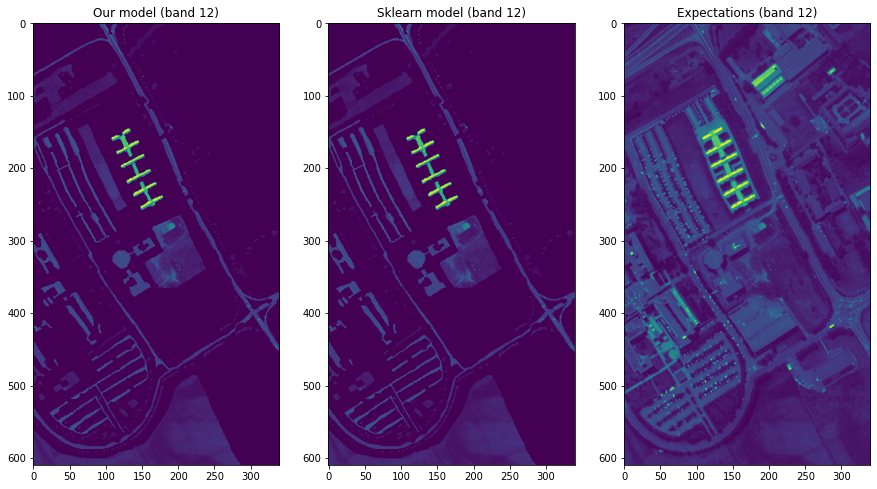

In [38]:
plt.figure(figsize=(15,12))

plt.subplot(1, 3, 1)
plt.title("Our model (band 12)")
plt.imshow(reconstruction_img)

plt.subplot(1, 3, 2)
plt.title("Sklearn model (band 12)")
plt.imshow(reconstruction_img_sk)

plt.subplot(1, 3, 3)
plt.title("Expectations (band 12)")
plt.imshow(hsi[:, :, 12])

plt.show()

Nous pouvons également noter que nous obtenons un résultat proche de celui de Ridge mais il est difficile de comparer visuellement ces deux images.

In [39]:
err = reconstruction_img - reconstruction_img_sk
print('Erreur moyenne: {}'.format(err.mean()))
print('Erreur maximale: {}'.format(err.max()))

Erreur moyenne: 1.899943968158327e-15
Erreur maximale: 3.1252778143198157e-14


Nous pouvons remarquer que l'erreur maximale commise est de l'ordre de $1e^{-13}$ ce qui est très faible. Nous pouvons également noté que l'erreur moyenne est 100 fois plus petite. Nous pouvons donc affirmer que nous obtenons la même solution.

**3.4) Idem que pour les moindres carrés ordinaires, adaptez votre implémentation pour obtenir d'un coup la matrice d'abondances $\boldsymbol \Phi$ pour toute l'image. Affichez ces cartes d'abondances fractionnelles et la carte d'erreur quadratique moyenne de reconstruction pour l'image entière. Qu'en est-il de l'influence de $\lambda$ ?**

In [40]:
coefs = np.zeros((Nrow * Ncol, 8))
coefs[usefull_idx] = clf.coef_
coefs = coefs.reshape((Nrow, Ncol, 8))

In [41]:
full_phi = np.zeros((Nrow * Ncol, 8))
full_phi[usefull_idx] = phi.T
full_phi = full_phi.reshape((Nrow, Ncol, 8))

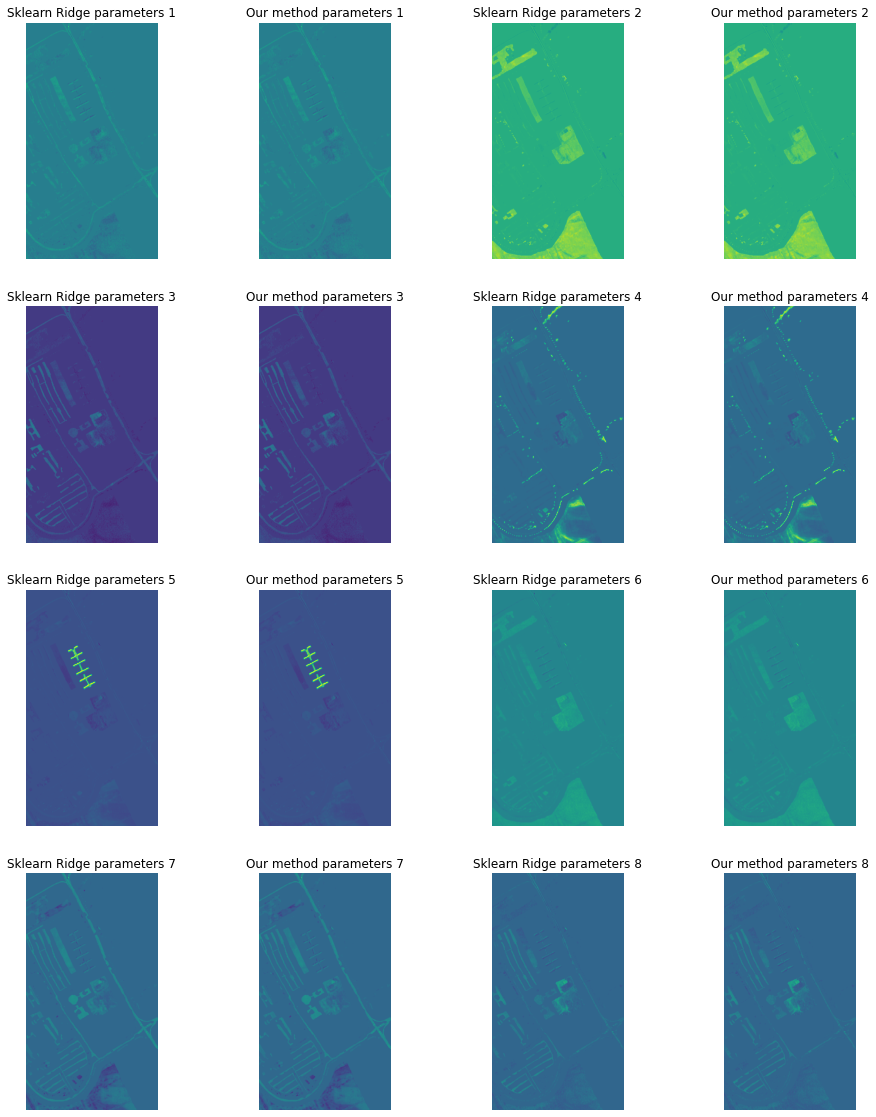

In [42]:
plt.figure(figsize=(16,20))

for i in range(8):
    plt.subplot(4, 4, 2 * i + 1)
    plt.title('Sklearn Ridge parameters {}'.format(i + 1))
    plt.imshow(coefs[:, :, i])
    plt.axis('off')
    
    plt.subplot(4, 4, 2 * i + 2)
    plt.title('Our method parameters {}'.format(i + 1))
    plt.imshow(full_phi[:, :, i])
    plt.axis('off')
    
plt.show()

En affichant les cartes d'abondances, nous pouvons noter que notre méthode nous permet d'avoir des résultats similaire à ceux de Ridge (de Sklearn). Nous parvenons à retrouver les mêmes motifs dans chaque carte.

In [43]:
phi_tikhonov = analytic_solution_tikhonov(E, hsi_usefull.T, 0.008)
x_tikhonov = E @ phi_tikhonov
mses = mean_square_error(hsi_usefull, x_tikhonov.T)

phi_tikhonov2 = analytic_solution_tikhonov(E, hsi_usefull.T, 1)
x_tikhonov2 = E @ phi_tikhonov2
mses2 = mean_square_error(hsi_usefull, x_tikhonov2.T)

phi_tikhonov3 = analytic_solution_tikhonov(E, hsi_usefull.T, 5)
x_tikhonov3 = E @ phi_tikhonov3
mses3 = mean_square_error(hsi_usefull, x_tikhonov3.T)

In [44]:
full_mses = np.zeros((Nrow * Ncol))
full_mses[usefull_idx] = mses
full_mses = full_mses.reshape((Nrow, Ncol))

full_mses2 = np.zeros((Nrow * Ncol))
full_mses2[usefull_idx] = mses2
full_mses2 = full_mses2.reshape((Nrow, Ncol))

full_mses3 = np.zeros((Nrow * Ncol))
full_mses3[usefull_idx] = mses3
full_mses3 = full_mses3.reshape((Nrow, Ncol))

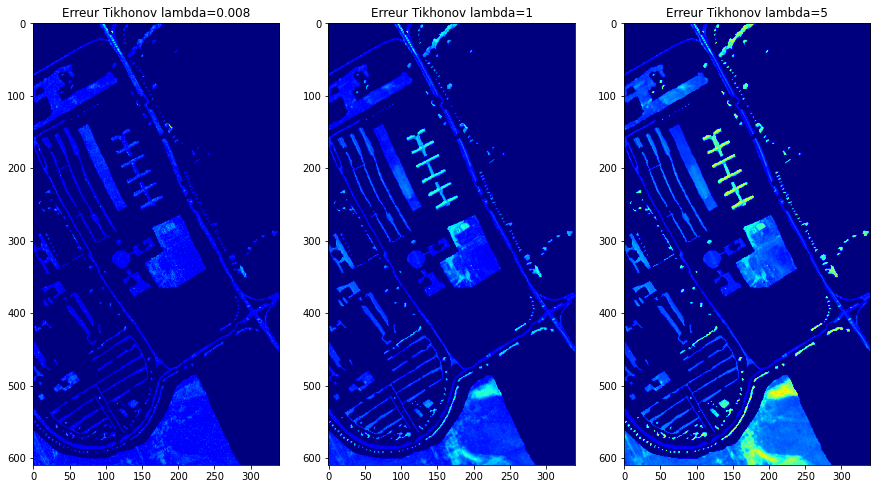

In [45]:
plt.figure(figsize=(15, 10))
plt.subplot(1, 3, 1)
plt.imshow(full_mses, cmap='jet')
plt.title('Erreur Tikhonov lambda=0.008')

plt.subplot(1, 3, 2)
plt.imshow(full_mses2, cmap='jet')
plt.title('Erreur Tikhonov lambda=1')

plt.subplot(1, 3, 3)
plt.imshow(full_mses3, cmap='jet')
plt.title('Erreur Tikhonov lambda=5')

plt.show()

Tout a l'heure, nous avons constater que l'erreur était plus petit lorsque lambda était plus petit.\
En affichant les cartes d'erreurs avec régularisation Tikhonov et différentes valeures de lambda, nous pouvons faire la même remarque.\
Sur la partie basse de l'image, nous remarquons qu'en augmentant lambda, l'erreur est plus importante (la couleur tend vers le jaune)

**3.5) Ré-appliquez la stratégie de classification du point 2.7) précédent, et étudiez les résultats qualitativement et quantitativement (toujours en fonction de $\lambda$). Quel est l'influence de la régularisation de Tikhonov sur les performances de classification ?**

In [46]:
classifier_tik_sk = np.argmax(clf.coef_.reshape(-1, 8), axis=1) + 1
full_classifier_tik_sk = np.zeros((Nrow * Ncol))
full_classifier_tik_sk[usefull_idx] = classifier_tik_sk
full_classifier_tik_sk = full_classifier_tik_sk.reshape((Nrow, Ncol))

In [47]:
classifier_tik = np.argmax(phi.T.reshape(-1, 8), axis=1) + 1
full_classifier_tik = np.zeros((Nrow * Ncol,))
full_classifier_tik[usefull_idx] = classifier_tik
full_classifier_tik = full_classifier_tik.reshape((Nrow, Ncol,))

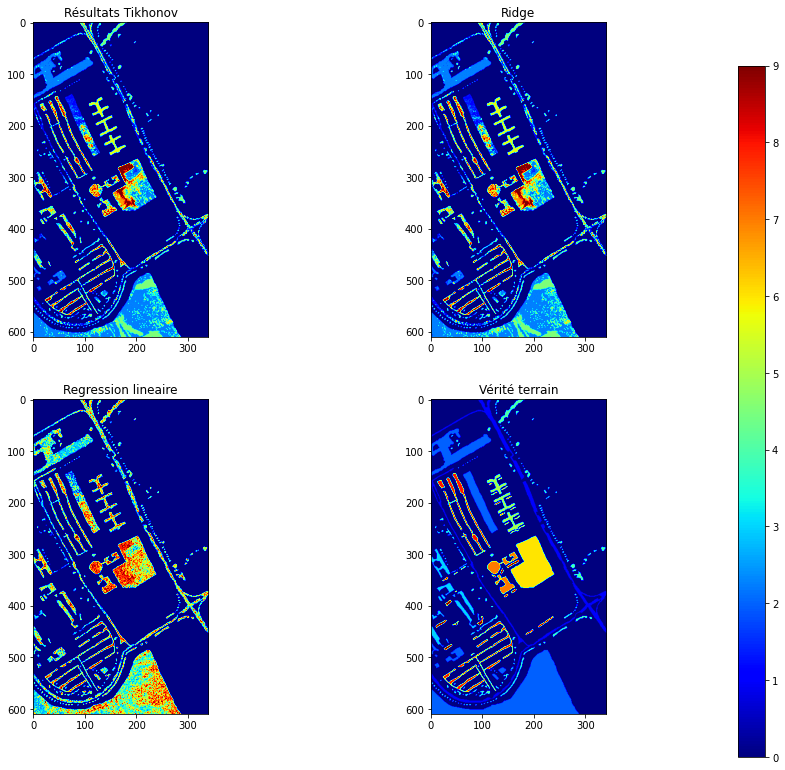

In [48]:
plt.figure(figsize=(15, 12))
plt.subplot(2, 2, 1)
plt.imshow(full_classifier_tik, cmap='jet')
plt.title('Résultats Tikhonov')

plt.subplot(2, 2, 2)
plt.imshow(full_classifier_tik_sk, cmap='jet')
plt.title('Ridge')

plt.subplot(2, 2, 3)
plt.imshow(full_classifier, cmap='jet')
plt.title('Regression lineaire')

plt.subplot(2, 2, 4)
plt.imshow(gt, cmap='jet')
plt.title('Vérité terrain')

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.85, 0.05, 0.025, 0.8])
plt.colorbar(imgt, cax=cax)

plt.show()

En comparant seulement Tikhonov et Ridge, nous remarquons une fois de plus que les résultats obtenus sont similaires.

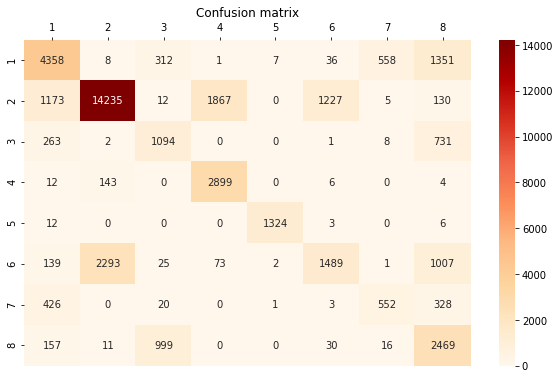

In [49]:
plot_confusion_matrix(gt[(gt != 0) & (gt != 9)], full_classifier_tik[full_classifier_tik != 0], class_names=np.arange(1, 9), log=False)

Sur cette matrice de confusion, la diagonale est un peu plus visible. On remarque notamment qu'il y a moins d'erreurs pour la classe 2.

In [50]:
print('Tikhonov: classification report')
print()
print(classification_report(gt[(gt != 0) & (gt != 9)], full_classifier_tik[full_classifier_tik != 0]))

Tikhonov: classification report

              precision    recall  f1-score   support

           1       0.67      0.66      0.66      6631
           2       0.85      0.76      0.81     18649
           3       0.44      0.52      0.48      2099
           4       0.60      0.95      0.73      3064
           5       0.99      0.98      0.99      1345
           6       0.53      0.30      0.38      5029
           7       0.48      0.42      0.45      1330
           8       0.41      0.67      0.51      3682

    accuracy                           0.68     41829
   macro avg       0.62      0.66      0.63     41829
weighted avg       0.70      0.68      0.68     41829



Nous remarquons sur le rapport de classification que la précision (accuracy) atteint 0.68 ce qui est correcte.\
Nous pouvons également noter que la classification pour la classe 5 est presque parfaite, puisque les trois métriques sont très proches de 1. A l'aide de la matrice de confusion, nous pouvons noter que l'erreur s'effectue sur 10 samples seulement.

### Influence de $\lambda$

In [51]:
classifier_tik2 = np.argmax(phi_tikhonov2.T.reshape(-1, 8), axis=1) + 1
full_classifier_tik2 = np.zeros((Nrow * Ncol))
full_classifier_tik2[usefull_idx] = classifier_tik2
full_classifier_tik2 = full_classifier_tik2.reshape((Nrow, Ncol))

classifier_tik3 = np.argmax(phi_tikhonov3.T.reshape(-1, 8), axis=1) + 1
full_classifier_tik3 = np.zeros((Nrow * Ncol))
full_classifier_tik3[usefull_idx] = classifier_tik3
full_classifier_tik3 = full_classifier_tik3.reshape((Nrow, Ncol))

In [52]:
print(classification_report(gt[(gt != 0) & (gt != 9)], full_classifier_tik2[full_classifier_tik2 != 0]))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00      6631
           2       0.81      0.02      0.03     18649
           3       0.06      0.00      0.01      2099
           4       0.13      1.00      0.23      3064
           5       0.50      1.00      0.67      1345
           6       0.56      0.04      0.08      5029
           7       0.00      0.00      0.00      1330
           8       0.25      1.00      0.41      3682

    accuracy                           0.21     41829
   macro avg       0.29      0.38      0.18     41829
weighted avg       0.48      0.21      0.10     41829



/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [53]:
print(classification_report(gt[(gt != 0) & (gt != 9)], full_classifier_tik3[full_classifier_tik3 != 0]))

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00      6631
           2       0.00      0.00      0.00     18649
           3       0.00      0.00      0.00      2099
           4       0.12      1.00      0.22      3064
           5       0.10      1.00      0.18      1345
           6       0.00      0.00      0.00      5029
           7       0.00      0.00      0.00      1330
           8       0.16      0.13      0.14      3682

    accuracy                           0.12     41829
   macro avg       0.05      0.27      0.07     41829
weighted avg       0.03      0.12      0.03     41829



/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Nous pouvons remarquer qu'avec un lambda croissant, la précision (accuracy) diminue. Nous parvenons à la même conclusion lorsqu'il fallait déterminer l'influence de lamda sur les cartes d'erreurs.

## IV. Régularisation LASSO

La régularisation LASSO (pour Least Absolute Shrinkage and Selection Operator), proposée en 1996 par Robert Tibshirani, est très similaire à celle de Tikhonov, sauf que la pénalité prend la forme d'une norme $\mathcal{L}_1$ plutôt qu'une norme $\mathcal{L}_2$. Plus particulièrement, le problème (4) précédent prend la forme de

$$ \arg\min_{\boldsymbol \phi \in \mathbb{R}^m} = \|\mathbf{x} -  \mathbf{E}\boldsymbol \phi \|_2^2 + \lambda \|\boldsymbol \phi \|_1\quad (5)$$

Cette régularisation, que l'on retrouve aussi sous le nom de _basis pursuit_ (une petite recherche bibliographique pourrait vous convaincre que les deux problèmes ne sont pas équivalents. Et pourtant, d'après la dualité Lagrangienne que vous verrez au S9, ils le sont).

Malgré sa forte ressemblance avec la régularisation de Tikhonov, la résolution du problème $(5)$ se passe moins bien puisqu'il n'existe pas de solution analytique dans le cas général (il en existe une dans le cas particulier où $E^T E = Id$, ce qui n'est clairement pas le cas dans notre étude). On doit donc se tourner vers des méthodes itératives, dont le splus utilisées pour la résolution de $(5)$ sont les méthodes LARS (Least Angle Regressions), de gradient proximaux et de descente de gradient par coordonnées.

Dans cette partie, vous allez implémenter la résolution de $(5)$ par descente de gradient par coordonnées. Bien qu'étant la plus abordable sur le plan théorique, cette méthode va vous amenez à toucher du doigt la notion de sous-différentiel, qui est au centre des algos de minimisation de fonctions convexes, mais non nécessairement différentiables.

**Cette partie n'est volontairement pas guidée. La partie II a permis de mettre en place un cadre de résolution et d'analyse du problème des moindres carrés, et la partie III a permis d'ajouter l'aspect régularisation au problème. À vous de jouer :**

**4.1) Cherchez** (vous trouverez une multitude de cours/slides/tutos plus ou moins clairs et didactiques sur le net)**, comprenez, et implémentez l'algorithme du LASSO par descente de gradient par coordonnées**

In [160]:
class Lasso:
    def __init__(self, num_iters=100, lb=0.01):
        self.num_iters = num_iters
        self.lb = lb
    
    def fit(self, E, x, display_mse=True):
        self.phi = np.random.uniform(size=(E.shape[1], x.shape[1]))
        
        # precompute z: shape=(E.shape[1],)=(n_features,)
        z = (E**2).sum(axis=0)
        
        mses = []

        # iterate over number of dimensions
        for i in range(self.num_iters):
            
            # compute loss function
            x_hat = E @ self.phi
            mse = ((x - x_hat)**2).sum(axis=0)[1000] / 2.0 + self.lb * np.sum(np.abs(self.phi), axis=0)[1000]
            if display_mse:
                print("{:3}\t{:.5f}".format(i, mse))
            
            mses.append(mse)
            # iterate over dimensions
            for j in range(E.shape[1]):             
                z_j = z[j]
                e_j = E[:, j].reshape((-1, 1))

                # don't want to consider this term in the sum
                print(e_j.shape)
                print(self.phi[j].shape)
                return
                theta_x_j = e_j * self.phi[j].reshape((1, -1))
                
                # compute rho term
                # preds: shape=(E.shape[0], x.shape[1])=(n_samples, nb_dim_pred_var)
                preds = E @ self.phi
                rho = e_j.T @ (x - preds + theta_x_j)
                
                # update learning params: phi
                rho = rho.reshape((rho.shape[1],))
                self.phi[j][rho < -self.lb] = (rho[rho < -self.lb] + self.lb) / z_j
                self.phi[j][(rho >= -self.lb) & (rho <= self.lb)] = 0.
                self.phi[j][rho > self.lb] = (rho[rho > self.lb] - self.lb) / z_j
        return mses

In [225]:
def soft_threshold(rho,lamda):
    '''Soft threshold function used for normalized data and lasso regression'''
    if rho < - lamda:
        return (rho + lamda)
    elif rho >  lamda:
        return (rho - lamda)
    else:
        return 0
    

def coordinate_descent_lasso(theta,X,y,lamda = 1.0, num_iters=100, intercept = False):
    '''Coordinate gradient descent for lasso regression - for normalized data. 
    The intercept parameter allows to specify whether or not we regularize theta_0'''
    
    #Initialisation of useful values 
    m,n = X.shape
    X = X / (np.linalg.norm(X,axis = 0)) #normalizing X in case it was not done before

    #Looping until max number of iterations
    for i in range(num_iters): 
        
        #Looping through each coordinate
        for j in range(n):
            
            #Vectorized implementation
            X_j = X[:,j]
            y_pred = X @ theta
            rho = X_j.T @ (y - y_pred.flatten()  + theta[j] * X_j)
        
            #Checking intercept parameter
            if intercept == True:  
                if j == 0: 
                    theta[j] =  rho 
                else:
                    theta[j] =  soft_threshold(rho, lamda)  

            if intercept == False:
                theta[j] =  soft_threshold(rho, lamda)   
            
    return theta.flatten()

In [226]:
list_phi = []

for idx, pixel in enumerate(hsi_usefull):
    phi = coordinate_descent_lasso(np.ones((E.shape[1],1)), E, pixel)
    list_phi.append(phi)
    print(idx)
    
phis = np.array(list_phi)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081


3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727


5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358
5359
5360
5361
5362
5363
5364
5365
5366
5367
5368
5369
5370
5371
5372
5373
5374
5375
5376
5377
5378
5379
5380


6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987
6988
6989
6990
6991
6992
6993
6994
6995
6996
6997
6998
6999
7000
7001
7002
7003
7004
7005
7006
7007
7008
7009
7010
7011
7012
7013
7014
7015
7016
7017
7018
7019
7020
7021
7022
7023


8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626
8627
8628
8629
8630
8631
8632
8633
8634
8635
8636
8637
8638
8639
8640
8641
8642
8643
8644
8645
8646
8647
8648
8649
8650
8651
8652
8653
8654
8655
8656
8657
8658
8659
8660
8661
8662
8663
8664
8665
8666
8667
8668
8669
8670
8671
8672
8673
8674
8675
8676
8677
8678
8679
8680
8681
8682
8683
8684
8685
8686
8687
8688
8689
8690
8691
8692
8693
8694
8695
8696
8697


10132
10133
10134
10135
10136
10137
10138
10139
10140
10141
10142
10143
10144
10145
10146
10147
10148
10149
10150
10151
10152
10153
10154
10155
10156
10157
10158
10159
10160
10161
10162
10163
10164
10165
10166
10167
10168
10169
10170
10171
10172
10173
10174
10175
10176
10177
10178
10179
10180
10181
10182
10183
10184
10185
10186
10187
10188
10189
10190
10191
10192
10193
10194
10195
10196
10197
10198
10199
10200
10201
10202
10203
10204
10205
10206
10207
10208
10209
10210
10211
10212
10213
10214
10215
10216
10217
10218
10219
10220
10221
10222
10223
10224
10225
10226
10227
10228
10229
10230
10231
10232
10233
10234
10235
10236
10237
10238
10239
10240
10241
10242
10243
10244
10245
10246
10247
10248
10249
10250
10251
10252
10253
10254
10255
10256
10257
10258
10259
10260
10261
10262
10263
10264
10265
10266
10267
10268
10269
10270
10271
10272
10273
10274
10275
10276
10277
10278
10279
10280
10281
10282
10283
10284
10285
10286
10287
10288
10289
10290
10291
10292
10293
10294
10295
10296
10297
1029

11503
11504
11505
11506
11507
11508
11509
11510
11511
11512
11513
11514
11515
11516
11517
11518
11519
11520
11521
11522
11523
11524
11525
11526
11527
11528
11529
11530
11531
11532
11533
11534
11535
11536
11537
11538
11539
11540
11541
11542
11543
11544
11545
11546
11547
11548
11549
11550
11551
11552
11553
11554
11555
11556
11557
11558
11559
11560
11561
11562
11563
11564
11565
11566
11567
11568
11569
11570
11571
11572
11573
11574
11575
11576
11577
11578
11579
11580
11581
11582
11583
11584
11585
11586
11587
11588
11589
11590
11591
11592
11593
11594
11595
11596
11597
11598
11599
11600
11601
11602
11603
11604
11605
11606
11607
11608
11609
11610
11611
11612
11613
11614
11615
11616
11617
11618
11619
11620
11621
11622
11623
11624
11625
11626
11627
11628
11629
11630
11631
11632
11633
11634
11635
11636
11637
11638
11639
11640
11641
11642
11643
11644
11645
11646
11647
11648
11649
11650
11651
11652
11653
11654
11655
11656
11657
11658
11659
11660
11661
11662
11663
11664
11665
11666
11667
11668
1166

12874
12875
12876
12877
12878
12879
12880
12881
12882
12883
12884
12885
12886
12887
12888
12889
12890
12891
12892
12893
12894
12895
12896
12897
12898
12899
12900
12901
12902
12903
12904
12905
12906
12907
12908
12909
12910
12911
12912
12913
12914
12915
12916
12917
12918
12919
12920
12921
12922
12923
12924
12925
12926
12927
12928
12929
12930
12931
12932
12933
12934
12935
12936
12937
12938
12939
12940
12941
12942
12943
12944
12945
12946
12947
12948
12949
12950
12951
12952
12953
12954
12955
12956
12957
12958
12959
12960
12961
12962
12963
12964
12965
12966
12967
12968
12969
12970
12971
12972
12973
12974
12975
12976
12977
12978
12979
12980
12981
12982
12983
12984
12985
12986
12987
12988
12989
12990
12991
12992
12993
12994
12995
12996
12997
12998
12999
13000
13001
13002
13003
13004
13005
13006
13007
13008
13009
13010
13011
13012
13013
13014
13015
13016
13017
13018
13019
13020
13021
13022
13023
13024
13025
13026
13027
13028
13029
13030
13031
13032
13033
13034
13035
13036
13037
13038
13039
1304

14261
14262
14263
14264
14265
14266
14267
14268
14269
14270
14271
14272
14273
14274
14275
14276
14277
14278
14279
14280
14281
14282
14283
14284
14285
14286
14287
14288
14289
14290
14291
14292
14293
14294
14295
14296
14297
14298
14299
14300
14301
14302
14303
14304
14305
14306
14307
14308
14309
14310
14311
14312
14313
14314
14315
14316
14317
14318
14319
14320
14321
14322
14323
14324
14325
14326
14327
14328
14329
14330
14331
14332
14333
14334
14335
14336
14337
14338
14339
14340
14341
14342
14343
14344
14345
14346
14347
14348
14349
14350
14351
14352
14353
14354
14355
14356
14357
14358
14359
14360
14361
14362
14363
14364
14365
14366
14367
14368
14369
14370
14371
14372
14373
14374
14375
14376
14377
14378
14379
14380
14381
14382
14383
14384
14385
14386
14387
14388
14389
14390
14391
14392
14393
14394
14395
14396
14397
14398
14399
14400
14401
14402
14403
14404
14405
14406
14407
14408
14409
14410
14411
14412
14413
14414
14415
14416
14417
14418
14419
14420
14421
14422
14423
14424
14425
14426
1442

15626
15627
15628
15629
15630
15631
15632
15633
15634
15635
15636
15637
15638
15639
15640
15641
15642
15643
15644
15645
15646
15647
15648
15649
15650
15651
15652
15653
15654
15655
15656
15657
15658
15659
15660
15661
15662
15663
15664
15665
15666
15667
15668
15669
15670
15671
15672
15673
15674
15675
15676
15677
15678
15679
15680
15681
15682
15683
15684
15685
15686
15687
15688
15689
15690
15691
15692
15693
15694
15695
15696
15697
15698
15699
15700
15701
15702
15703
15704
15705
15706
15707
15708
15709
15710
15711
15712
15713
15714
15715
15716
15717
15718
15719
15720
15721
15722
15723
15724
15725
15726
15727
15728
15729
15730
15731
15732
15733
15734
15735
15736
15737
15738
15739
15740
15741
15742
15743
15744
15745
15746
15747
15748
15749
15750
15751
15752
15753
15754
15755
15756
15757
15758
15759
15760
15761
15762
15763
15764
15765
15766
15767
15768
15769
15770
15771
15772
15773
15774
15775
15776
15777
15778
15779
15780
15781
15782
15783
15784
15785
15786
15787
15788
15789
15790
15791
1579

16996
16997
16998
16999
17000
17001
17002
17003
17004
17005
17006
17007
17008
17009
17010
17011
17012
17013
17014
17015
17016
17017
17018
17019
17020
17021
17022
17023
17024
17025
17026
17027
17028
17029
17030
17031
17032
17033
17034
17035
17036
17037
17038
17039
17040
17041
17042
17043
17044
17045
17046
17047
17048
17049
17050
17051
17052
17053
17054
17055
17056
17057
17058
17059
17060
17061
17062
17063
17064
17065
17066
17067
17068
17069
17070
17071
17072
17073
17074
17075
17076
17077
17078
17079
17080
17081
17082
17083
17084
17085
17086
17087
17088
17089
17090
17091
17092
17093
17094
17095
17096
17097
17098
17099
17100
17101
17102
17103
17104
17105
17106
17107
17108
17109
17110
17111
17112
17113
17114
17115
17116
17117
17118
17119
17120
17121
17122
17123
17124
17125
17126
17127
17128
17129
17130
17131
17132
17133
17134
17135
17136
17137
17138
17139
17140
17141
17142
17143
17144
17145
17146
17147
17148
17149
17150
17151
17152
17153
17154
17155
17156
17157
17158
17159
17160
17161
1716

18388
18389
18390
18391
18392
18393
18394
18395
18396
18397
18398
18399
18400
18401
18402
18403
18404
18405
18406
18407
18408
18409
18410
18411
18412
18413
18414
18415
18416
18417
18418
18419
18420
18421
18422
18423
18424
18425
18426
18427
18428
18429
18430
18431
18432
18433
18434
18435
18436
18437
18438
18439
18440
18441
18442
18443
18444
18445
18446
18447
18448
18449
18450
18451
18452
18453
18454
18455
18456
18457
18458
18459
18460
18461
18462
18463
18464
18465
18466
18467
18468
18469
18470
18471
18472
18473
18474
18475
18476
18477
18478
18479
18480
18481
18482
18483
18484
18485
18486
18487
18488
18489
18490
18491
18492
18493
18494
18495
18496
18497
18498
18499
18500
18501
18502
18503
18504
18505
18506
18507
18508
18509
18510
18511
18512
18513
18514
18515
18516
18517
18518
18519
18520
18521
18522
18523
18524
18525
18526
18527
18528
18529
18530
18531
18532
18533
18534
18535
18536
18537
18538
18539
18540
18541
18542
18543
18544
18545
18546
18547
18548
18549
18550
18551
18552
18553
1855

19755
19756
19757
19758
19759
19760
19761
19762
19763
19764
19765
19766
19767
19768
19769
19770
19771
19772
19773
19774
19775
19776
19777
19778
19779
19780
19781
19782
19783
19784
19785
19786
19787
19788
19789
19790
19791
19792
19793
19794
19795
19796
19797
19798
19799
19800
19801
19802
19803
19804
19805
19806
19807
19808
19809
19810
19811
19812
19813
19814
19815
19816
19817
19818
19819
19820
19821
19822
19823
19824
19825
19826
19827
19828
19829
19830
19831
19832
19833
19834
19835
19836
19837
19838
19839
19840
19841
19842
19843
19844
19845
19846
19847
19848
19849
19850
19851
19852
19853
19854
19855
19856
19857
19858
19859
19860
19861
19862
19863
19864
19865
19866
19867
19868
19869
19870
19871
19872
19873
19874
19875
19876
19877
19878
19879
19880
19881
19882
19883
19884
19885
19886
19887
19888
19889
19890
19891
19892
19893
19894
19895
19896
19897
19898
19899
19900
19901
19902
19903
19904
19905
19906
19907
19908
19909
19910
19911
19912
19913
19914
19915
19916
19917
19918
19919
19920
1992

21128
21129
21130
21131
21132
21133
21134
21135
21136
21137
21138
21139
21140
21141
21142
21143
21144
21145
21146
21147
21148
21149
21150
21151
21152
21153
21154
21155
21156
21157
21158
21159
21160
21161
21162
21163
21164
21165
21166
21167
21168
21169
21170
21171
21172
21173
21174
21175
21176
21177
21178
21179
21180
21181
21182
21183
21184
21185
21186
21187
21188
21189
21190
21191
21192
21193
21194
21195
21196
21197
21198
21199
21200
21201
21202
21203
21204
21205
21206
21207
21208
21209
21210
21211
21212
21213
21214
21215
21216
21217
21218
21219
21220
21221
21222
21223
21224
21225
21226
21227
21228
21229
21230
21231
21232
21233
21234
21235
21236
21237
21238
21239
21240
21241
21242
21243
21244
21245
21246
21247
21248
21249
21250
21251
21252
21253
21254
21255
21256
21257
21258
21259
21260
21261
21262
21263
21264
21265
21266
21267
21268
21269
21270
21271
21272
21273
21274
21275
21276
21277
21278
21279
21280
21281
21282
21283
21284
21285
21286
21287
21288
21289
21290
21291
21292
21293
2129

22519
22520
22521
22522
22523
22524
22525
22526
22527
22528
22529
22530
22531
22532
22533
22534
22535
22536
22537
22538
22539
22540
22541
22542
22543
22544
22545
22546
22547
22548
22549
22550
22551
22552
22553
22554
22555
22556
22557
22558
22559
22560
22561
22562
22563
22564
22565
22566
22567
22568
22569
22570
22571
22572
22573
22574
22575
22576
22577
22578
22579
22580
22581
22582
22583
22584
22585
22586
22587
22588
22589
22590
22591
22592
22593
22594
22595
22596
22597
22598
22599
22600
22601
22602
22603
22604
22605
22606
22607
22608
22609
22610
22611
22612
22613
22614
22615
22616
22617
22618
22619
22620
22621
22622
22623
22624
22625
22626
22627
22628
22629
22630
22631
22632
22633
22634
22635
22636
22637
22638
22639
22640
22641
22642
22643
22644
22645
22646
22647
22648
22649
22650
22651
22652
22653
22654
22655
22656
22657
22658
22659
22660
22661
22662
22663
22664
22665
22666
22667
22668
22669
22670
22671
22672
22673
22674
22675
22676
22677
22678
22679
22680
22681
22682
22683
22684
2268

23888
23889
23890
23891
23892
23893
23894
23895
23896
23897
23898
23899
23900
23901
23902
23903
23904
23905
23906
23907
23908
23909
23910
23911
23912
23913
23914
23915
23916
23917
23918
23919
23920
23921
23922
23923
23924
23925
23926
23927
23928
23929
23930
23931
23932
23933
23934
23935
23936
23937
23938
23939
23940
23941
23942
23943
23944
23945
23946
23947
23948
23949
23950
23951
23952
23953
23954
23955
23956
23957
23958
23959
23960
23961
23962
23963
23964
23965
23966
23967
23968
23969
23970
23971
23972
23973
23974
23975
23976
23977
23978
23979
23980
23981
23982
23983
23984
23985
23986
23987
23988
23989
23990
23991
23992
23993
23994
23995
23996
23997
23998
23999
24000
24001
24002
24003
24004
24005
24006
24007
24008
24009
24010
24011
24012
24013
24014
24015
24016
24017
24018
24019
24020
24021
24022
24023
24024
24025
24026
24027
24028
24029
24030
24031
24032
24033
24034
24035
24036
24037
24038
24039
24040
24041
24042
24043
24044
24045
24046
24047
24048
24049
24050
24051
24052
24053
2405

25258
25259
25260
25261
25262
25263
25264
25265
25266
25267
25268
25269
25270
25271
25272
25273
25274
25275
25276
25277
25278
25279
25280
25281
25282
25283
25284
25285
25286
25287
25288
25289
25290
25291
25292
25293
25294
25295
25296
25297
25298
25299
25300
25301
25302
25303
25304
25305
25306
25307
25308
25309
25310
25311
25312
25313
25314
25315
25316
25317
25318
25319
25320
25321
25322
25323
25324
25325
25326
25327
25328
25329
25330
25331
25332
25333
25334
25335
25336
25337
25338
25339
25340
25341
25342
25343
25344
25345
25346
25347
25348
25349
25350
25351
25352
25353
25354
25355
25356
25357
25358
25359
25360
25361
25362
25363
25364
25365
25366
25367
25368
25369
25370
25371
25372
25373
25374
25375
25376
25377
25378
25379
25380
25381
25382
25383
25384
25385
25386
25387
25388
25389
25390
25391
25392
25393
25394
25395
25396
25397
25398
25399
25400
25401
25402
25403
25404
25405
25406
25407
25408
25409
25410
25411
25412
25413
25414
25415
25416
25417
25418
25419
25420
25421
25422
25423
2542

26643
26644
26645
26646
26647
26648
26649
26650
26651
26652
26653
26654
26655
26656
26657
26658
26659
26660
26661
26662
26663
26664
26665
26666
26667
26668
26669
26670
26671
26672
26673
26674
26675
26676
26677
26678
26679
26680
26681
26682
26683
26684
26685
26686
26687
26688
26689
26690
26691
26692
26693
26694
26695
26696
26697
26698
26699
26700
26701
26702
26703
26704
26705
26706
26707
26708
26709
26710
26711
26712
26713
26714
26715
26716
26717
26718
26719
26720
26721
26722
26723
26724
26725
26726
26727
26728
26729
26730
26731
26732
26733
26734
26735
26736
26737
26738
26739
26740
26741
26742
26743
26744
26745
26746
26747
26748
26749
26750
26751
26752
26753
26754
26755
26756
26757
26758
26759
26760
26761
26762
26763
26764
26765
26766
26767
26768
26769
26770
26771
26772
26773
26774
26775
26776
26777
26778
26779
26780
26781
26782
26783
26784
26785
26786
26787
26788
26789
26790
26791
26792
26793
26794
26795
26796
26797
26798
26799
26800
26801
26802
26803
26804
26805
26806
26807
26808
2680

28011
28012
28013
28014
28015
28016
28017
28018
28019
28020
28021
28022
28023
28024
28025
28026
28027
28028
28029
28030
28031
28032
28033
28034
28035
28036
28037
28038
28039
28040
28041
28042
28043
28044
28045
28046
28047
28048
28049
28050
28051
28052
28053
28054
28055
28056
28057
28058
28059
28060
28061
28062
28063
28064
28065
28066
28067
28068
28069
28070
28071
28072
28073
28074
28075
28076
28077
28078
28079
28080
28081
28082
28083
28084
28085
28086
28087
28088
28089
28090
28091
28092
28093
28094
28095
28096
28097
28098
28099
28100
28101
28102
28103
28104
28105
28106
28107
28108
28109
28110
28111
28112
28113
28114
28115
28116
28117
28118
28119
28120
28121
28122
28123
28124
28125
28126
28127
28128
28129
28130
28131
28132
28133
28134
28135
28136
28137
28138
28139
28140
28141
28142
28143
28144
28145
28146
28147
28148
28149
28150
28151
28152
28153
28154
28155
28156
28157
28158
28159
28160
28161
28162
28163
28164
28165
28166
28167
28168
28169
28170
28171
28172
28173
28174
28175
28176
2817

29387
29388
29389
29390
29391
29392
29393
29394
29395
29396
29397
29398
29399
29400
29401
29402
29403
29404
29405
29406
29407
29408
29409
29410
29411
29412
29413
29414
29415
29416
29417
29418
29419
29420
29421
29422
29423
29424
29425
29426
29427
29428
29429
29430
29431
29432
29433
29434
29435
29436
29437
29438
29439
29440
29441
29442
29443
29444
29445
29446
29447
29448
29449
29450
29451
29452
29453
29454
29455
29456
29457
29458
29459
29460
29461
29462
29463
29464
29465
29466
29467
29468
29469
29470
29471
29472
29473
29474
29475
29476
29477
29478
29479
29480
29481
29482
29483
29484
29485
29486
29487
29488
29489
29490
29491
29492
29493
29494
29495
29496
29497
29498
29499
29500
29501
29502
29503
29504
29505
29506
29507
29508
29509
29510
29511
29512
29513
29514
29515
29516
29517
29518
29519
29520
29521
29522
29523
29524
29525
29526
29527
29528
29529
29530
29531
29532
29533
29534
29535
29536
29537
29538
29539
29540
29541
29542
29543
29544
29545
29546
29547
29548
29549
29550
29551
29552
2955

30783
30784
30785
30786
30787
30788
30789
30790
30791
30792
30793
30794
30795
30796
30797
30798
30799
30800
30801
30802
30803
30804
30805
30806
30807
30808
30809
30810
30811
30812
30813
30814
30815
30816
30817
30818
30819
30820
30821
30822
30823
30824
30825
30826
30827
30828
30829
30830
30831
30832
30833
30834
30835
30836
30837
30838
30839
30840
30841
30842
30843
30844
30845
30846
30847
30848
30849
30850
30851
30852
30853
30854
30855
30856
30857
30858
30859
30860
30861
30862
30863
30864
30865
30866
30867
30868
30869
30870
30871
30872
30873
30874
30875
30876
30877
30878
30879
30880
30881
30882
30883
30884
30885
30886
30887
30888
30889
30890
30891
30892
30893
30894
30895
30896
30897
30898
30899
30900
30901
30902
30903
30904
30905
30906
30907
30908
30909
30910
30911
30912
30913
30914
30915
30916
30917
30918
30919
30920
30921
30922
30923
30924
30925
30926
30927
30928
30929
30930
30931
30932
30933
30934
30935
30936
30937
30938
30939
30940
30941
30942
30943
30944
30945
30946
30947
30948
3094

32178
32179
32180
32181
32182
32183
32184
32185
32186
32187
32188
32189
32190
32191
32192
32193
32194
32195
32196
32197
32198
32199
32200
32201
32202
32203
32204
32205
32206
32207
32208
32209
32210
32211
32212
32213
32214
32215
32216
32217
32218
32219
32220
32221
32222
32223
32224
32225
32226
32227
32228
32229
32230
32231
32232
32233
32234
32235
32236
32237
32238
32239
32240
32241
32242
32243
32244
32245
32246
32247
32248
32249
32250
32251
32252
32253
32254
32255
32256
32257
32258
32259
32260
32261
32262
32263
32264
32265
32266
32267
32268
32269
32270
32271
32272
32273
32274
32275
32276
32277
32278
32279
32280
32281
32282
32283
32284
32285
32286
32287
32288
32289
32290
32291
32292
32293
32294
32295
32296
32297
32298
32299
32300
32301
32302
32303
32304
32305
32306
32307
32308
32309
32310
32311
32312
32313
32314
32315
32316
32317
32318
32319
32320
32321
32322
32323
32324
32325
32326
32327
32328
32329
32330
32331
32332
32333
32334
32335
32336
32337
32338
32339
32340
32341
32342
32343
3234

33548
33549
33550
33551
33552
33553
33554
33555
33556
33557
33558
33559
33560
33561
33562
33563
33564
33565
33566
33567
33568
33569
33570
33571
33572
33573
33574
33575
33576
33577
33578
33579
33580
33581
33582
33583
33584
33585
33586
33587
33588
33589
33590
33591
33592
33593
33594
33595
33596
33597
33598
33599
33600
33601
33602
33603
33604
33605
33606
33607
33608
33609
33610
33611
33612
33613
33614
33615
33616
33617
33618
33619
33620
33621
33622
33623
33624
33625
33626
33627
33628
33629
33630
33631
33632
33633
33634
33635
33636
33637
33638
33639
33640
33641
33642
33643
33644
33645
33646
33647
33648
33649
33650
33651
33652
33653
33654
33655
33656
33657
33658
33659
33660
33661
33662
33663
33664
33665
33666
33667
33668
33669
33670
33671
33672
33673
33674
33675
33676
33677
33678
33679
33680
33681
33682
33683
33684
33685
33686
33687
33688
33689
33690
33691
33692
33693
33694
33695
33696
33697
33698
33699
33700
33701
33702
33703
33704
33705
33706
33707
33708
33709
33710
33711
33712
33713
3371

34936
34937
34938
34939
34940
34941
34942
34943
34944
34945
34946
34947
34948
34949
34950
34951
34952
34953
34954
34955
34956
34957
34958
34959
34960
34961
34962
34963
34964
34965
34966
34967
34968
34969
34970
34971
34972
34973
34974
34975
34976
34977
34978
34979
34980
34981
34982
34983
34984
34985
34986
34987
34988
34989
34990
34991
34992
34993
34994
34995
34996
34997
34998
34999
35000
35001
35002
35003
35004
35005
35006
35007
35008
35009
35010
35011
35012
35013
35014
35015
35016
35017
35018
35019
35020
35021
35022
35023
35024
35025
35026
35027
35028
35029
35030
35031
35032
35033
35034
35035
35036
35037
35038
35039
35040
35041
35042
35043
35044
35045
35046
35047
35048
35049
35050
35051
35052
35053
35054
35055
35056
35057
35058
35059
35060
35061
35062
35063
35064
35065
35066
35067
35068
35069
35070
35071
35072
35073
35074
35075
35076
35077
35078
35079
35080
35081
35082
35083
35084
35085
35086
35087
35088
35089
35090
35091
35092
35093
35094
35095
35096
35097
35098
35099
35100
35101
3510

36327
36328
36329
36330
36331
36332
36333
36334
36335
36336
36337
36338
36339
36340
36341
36342
36343
36344
36345
36346
36347
36348
36349
36350
36351
36352
36353
36354
36355
36356
36357
36358
36359
36360
36361
36362
36363
36364
36365
36366
36367
36368
36369
36370
36371
36372
36373
36374
36375
36376
36377
36378
36379
36380
36381
36382
36383
36384
36385
36386
36387
36388
36389
36390
36391
36392
36393
36394
36395
36396
36397
36398
36399
36400
36401
36402
36403
36404
36405
36406
36407
36408
36409
36410
36411
36412
36413
36414
36415
36416
36417
36418
36419
36420
36421
36422
36423
36424
36425
36426
36427
36428
36429
36430
36431
36432
36433
36434
36435
36436
36437
36438
36439
36440
36441
36442
36443
36444
36445
36446
36447
36448
36449
36450
36451
36452
36453
36454
36455
36456
36457
36458
36459
36460
36461
36462
36463
36464
36465
36466
36467
36468
36469
36470
36471
36472
36473
36474
36475
36476
36477
36478
36479
36480
36481
36482
36483
36484
36485
36486
36487
36488
36489
36490
36491
36492
3649

37720
37721
37722
37723
37724
37725
37726
37727
37728
37729
37730
37731
37732
37733
37734
37735
37736
37737
37738
37739
37740
37741
37742
37743
37744
37745
37746
37747
37748
37749
37750
37751
37752
37753
37754
37755
37756
37757
37758
37759
37760
37761
37762
37763
37764
37765
37766
37767
37768
37769
37770
37771
37772
37773
37774
37775
37776
37777
37778
37779
37780
37781
37782
37783
37784
37785
37786
37787
37788
37789
37790
37791
37792
37793
37794
37795
37796
37797
37798
37799
37800
37801
37802
37803
37804
37805
37806
37807
37808
37809
37810
37811
37812
37813
37814
37815
37816
37817
37818
37819
37820
37821
37822
37823
37824
37825
37826
37827
37828
37829
37830
37831
37832
37833
37834
37835
37836
37837
37838
37839
37840
37841
37842
37843
37844
37845
37846
37847
37848
37849
37850
37851
37852
37853
37854
37855
37856
37857
37858
37859
37860
37861
37862
37863
37864
37865
37866
37867
37868
37869
37870
37871
37872
37873
37874
37875
37876
37877
37878
37879
37880
37881
37882
37883
37884
37885
3788

39096
39097
39098
39099
39100
39101
39102
39103
39104
39105
39106
39107
39108
39109
39110
39111
39112
39113
39114
39115
39116
39117
39118
39119
39120
39121
39122
39123
39124
39125
39126
39127
39128
39129
39130
39131
39132
39133
39134
39135
39136
39137
39138
39139
39140
39141
39142
39143
39144
39145
39146
39147
39148
39149
39150
39151
39152
39153
39154
39155
39156
39157
39158
39159
39160
39161
39162
39163
39164
39165
39166
39167
39168
39169
39170
39171
39172
39173
39174
39175
39176
39177
39178
39179
39180
39181
39182
39183
39184
39185
39186
39187
39188
39189
39190
39191
39192
39193
39194
39195
39196
39197
39198
39199
39200
39201
39202
39203
39204
39205
39206
39207
39208
39209
39210
39211
39212
39213
39214
39215
39216
39217
39218
39219
39220
39221
39222
39223
39224
39225
39226
39227
39228
39229
39230
39231
39232
39233
39234
39235
39236
39237
39238
39239
39240
39241
39242
39243
39244
39245
39246
39247
39248
39249
39250
39251
39252
39253
39254
39255
39256
39257
39258
39259
39260
39261
3926

40465
40466
40467
40468
40469
40470
40471
40472
40473
40474
40475
40476
40477
40478
40479
40480
40481
40482
40483
40484
40485
40486
40487
40488
40489
40490
40491
40492
40493
40494
40495
40496
40497
40498
40499
40500
40501
40502
40503
40504
40505
40506
40507
40508
40509
40510
40511
40512
40513
40514
40515
40516
40517
40518
40519
40520
40521
40522
40523
40524
40525
40526
40527
40528
40529
40530
40531
40532
40533
40534
40535
40536
40537
40538
40539
40540
40541
40542
40543
40544
40545
40546
40547
40548
40549
40550
40551
40552
40553
40554
40555
40556
40557
40558
40559
40560
40561
40562
40563
40564
40565
40566
40567
40568
40569
40570
40571
40572
40573
40574
40575
40576
40577
40578
40579
40580
40581
40582
40583
40584
40585
40586
40587
40588
40589
40590
40591
40592
40593
40594
40595
40596
40597
40598
40599
40600
40601
40602
40603
40604
40605
40606
40607
40608
40609
40610
40611
40612
40613
40614
40615
40616
40617
40618
40619
40620
40621
40622
40623
40624
40625
40626
40627
40628
40629
40630
4063

In [227]:
phis.shape

(41829, 8)

In [201]:
lasso_sk = Lasso_sk(alpha=0.01, max_iter=1000, fit_intercept=False)
lasso_sk.fit(E, hsi_usefull[0].T)

Lasso(alpha=0.01, fit_intercept=False)

In [202]:
lasso_sk.coef_

array([0.        , 0.        , 0.        , 0.        , 0.16504128,
       0.        , 0.        , 0.59032353])

In [162]:
l_model = Lasso(lb=0.0004, num_iters=60)
l_model.fit(E, hsi_usefull.T, True)

  0	49.18728
(103, 1)
(41829,)



**4.2) Menez à bien l'analyse qualitative et quantitative des performances du LASSO sur le problème de démélange spectral (aussi bien sur quelques spectres que sur l'image entière), ainsi que toutes les comparaisons qui vous paraîtront pertinentes avec la résolution par moindres carrés ordinaires et moindres carrés avec régularisation de Tikhonov**

In [155]:
l_model.phi.shape

(8, 41829)

In [228]:
classifier_l = np.argmax(phis, axis=1) + 1

full_classifier_l = np.zeros((Nrow * Ncol))
full_classifier_l[usefull_idx] = classifier_l
full_classifier_l = full_classifier_l.reshape((Nrow, Ncol))

In [229]:
classifier_l.shape

(41829,)

In [230]:
gt_usefull.shape

(41829,)

In [231]:
hsi_usefull.shape

(41829, 103)

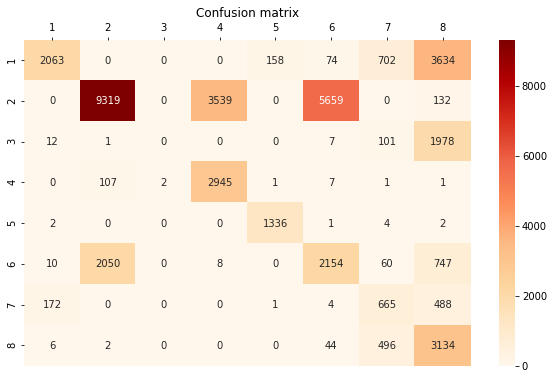

In [232]:
plot_confusion_matrix(gt_usefull, classifier_l, class_names=np.arange(1, 9), log=False)

En regardant la matrice de confusion, il semblerait que la classification soit décevante. En effet, nous parvenons a distinguer facilement les lignes de la matrice alors qu'il faudrait que ce soit la diagonale qui soit mise en valeur. Nous allons donc afficher le rapport de classification.

In [233]:
print(classification_report(gt_usefull, full_classifier_l[full_classifier_l != 0]))

              precision    recall  f1-score   support

           1       0.91      0.31      0.46      6631
           2       0.81      0.50      0.62     18649
           3       0.00      0.00      0.00      2099
           4       0.45      0.96      0.62      3064
           5       0.89      0.99      0.94      1345
           6       0.27      0.43      0.33      5029
           7       0.33      0.50      0.40      1330
           8       0.31      0.85      0.45      3682

    accuracy                           0.52     41829
   macro avg       0.50      0.57      0.48     41829
weighted avg       0.64      0.52      0.52     41829



En affichant ce rapport, cela nous permet seulement de confirmer l'hypothèse précédente. En effet, nous obtenons seulement une précision (accuracy) de 0.13 pour l'ensemble des données ce qui est très faible.

### Carte d'erreurs

In [59]:
x_hat = E @ l_model.phi
mses = mean_square_error(hsi_usefull, x_hat.T)

# Build image from errors
full_mses = np.zeros((Nrow * Ncol))
full_mses[usefull_idx] = mses
full_mses = full_mses.reshape((Nrow, Ncol))

In [60]:
print('Min error:\t {}'.format(mses.min()))
print('Max error:\t {}'.format(mses.max()))
print('Mean error:\t {}'.format(mses.mean()))

Min error:	 0.003271021210654882
Max error:	 0.07352998487811084
Mean error:	 0.012525883166063227


En regardant les valeurs maximale, minimale et moyenne, nous remarquons que ce modèle ne semble pas adapter à répondre à nos besoins. Nous allons alors comparer la carte d'erreur avec celles obtenus avec régularisation Tikhonov avec lambda = 1 et 5.

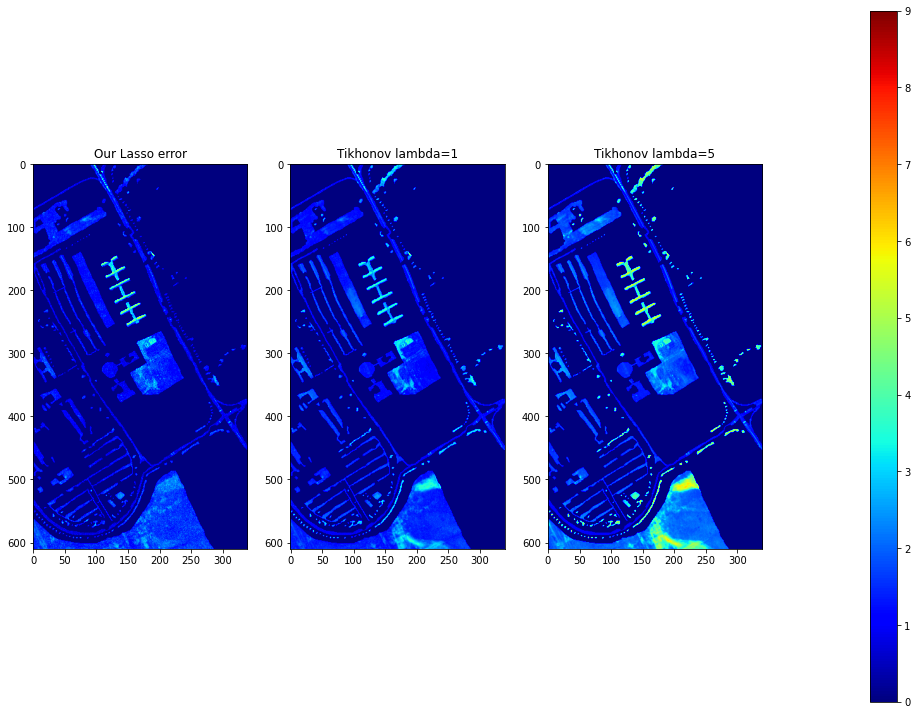

In [61]:
plt.figure(figsize=(15, 12))
plt.subplot(1, 3, 1)
plt.imshow(full_mses, cmap='jet')
plt.title('Our Lasso error')

plt.subplot(1, 3, 2)
plt.imshow(full_mses2, cmap='jet')
plt.title('Tikhonov lambda=1')

plt.subplot(1, 3, 3)
plt.imshow(full_mses3, cmap='jet')
plt.title('Tikhonov lambda=5')

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.9, 0.1, 0.025, 0.8])
plt.colorbar(imgt, cax=cax)

plt.show()

Nous pouvons remarquer que l'erreur obtenue avec Lasso est plus petite que celle obtenue avec Tikhonov lambda=5. En effet, sur la carte de Lasso, les couleurs sont toutes dans un ton bleu alors qu'il y a du jaune pour Tikhonov lambda=5.\

Nous pouvons également noter que les erreurs obtenues avec Lasso et avec Tikhonov lambda=1 sont très proches. Nous pouvons remarquer une légère différence sur la partie basse de l'image. Il semblerait que Lasso nous donne des résultats similaires à ceux de Tikhonov lambda=1.

### Comparaison: Lasso Sklearn - notre Lasso

Pour effectuer la comparaison, nous utilisons la même valeur de lambda/alpha.

In [77]:
lasso_sk = Lasso_sk(alpha=0.0004, max_iter=2000, fit_intercept=False)
lasso_sk.fit(E, hsi_usefull.T)

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002405732135532721, tolerance: 0.0008507749655813004
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009039310029649583, tolerance: 0.0006282974558289775
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007570538298079382, tolerance: 0.0006203276132016647
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0027807450483204182, tolerance: 0.0007733195332884436
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018860396867604653, tolerance: 0.0006477771220642117
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003697819693095794, tolerance: 0.000713229660867377
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000589476682126968, tolerance: 0.0004691398406218814
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009643718246999895, tolerance: 0.0013212026866339503
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0038790758595360006, tolerance: 0.0011335457841709195
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003917523216014178, tolerance: 0.0003015440963019329
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002696142175748463, tolerance: 0.0008109336109875312
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004045799960340126, tolerance: 0.0003805700105982971
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00028238514688237563, tolerance: 0.00023561396583294544
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001485198376630529, tolerance: 0.00044590955869343784
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0024523758127678735, tolerance: 0.0004933211699480734
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/pyth

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009185106355008646, tolerance: 0.0005269460387576461
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003115115373406011, tolerance: 0.0005254350755536624
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011592120070113635, tolerance: 0.00042770860727297394
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014181939060998183, tolerance: 0.0004795306941583973
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022867712606738904, tolerance: 0.000483025660289366
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005857719509172674, tolerance: 0.0005273787792934696
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003630725444778724, tolerance: 0.0006247023603755955
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003467180625454362, tolerance: 0.0005122363845378231
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012761784673762863, tolerance: 0.000507180399935414
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003301925528210641, tolerance: 0.0005830562570748359
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005591766918375176, tolerance: 0.0005047334488567753
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008460757840347936, tolerance: 0.00046489126761301274
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004957269543374668, tolerance: 0.00039471251582444275
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001306341613571075, tolerance: 0.0005312426648232732
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014144360153394743, tolerance: 0.0005612122403460165
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004123752070829892, tolerance: 0.0003229408604932588
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001016276741684325, tolerance: 0.0005066414134040115
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008483201682364609, tolerance: 0.0005216427381911437
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003091202486264939, tolerance: 0.00026990595997468094
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001212917453226256, tolerance: 0.00037370250842109424
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013433905531230247, tolerance: 0.0003951773695653667
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/pytho

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018423231967940566, tolerance: 0.0006034209648529895
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012527822168735755, tolerance: 0.0004107886117476198
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009178154142713175, tolerance: 0.0003597770283414267
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00048223741344615746, tolerance: 0.00048095513555771596
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00047615421780467133, tolerance: 0.0004571013636074748
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00046411085731970763, tolerance: 0.0004546119688827472
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/py

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005467313294027012, tolerance: 0.0005027692211153461
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013730212516942708, tolerance: 0.000681984712020908
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005437743026036517, tolerance: 0.0009116167056945662
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008859144121266416, tolerance: 0.0007899819709783585
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011747336748505997, tolerance: 0.0007940416464119525
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00512389039369514, tolerance: 0.0009263330992589781
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010223146895151662, tolerance: 0.0007384958126420337
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011214442516940364, tolerance: 0.0008655457382220627
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0028864009001960903, tolerance: 0.0009183000286428854
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000493478792221282, tolerance: 0.00044911674058563763
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0030579316794580765, tolerance: 0.0008349798823451609
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005576605225515218, tolerance: 0.0005058904636153764
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00041192047423231105, tolerance: 0.00034765348957948634
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004206957993527268, tolerance: 0.0003410149533468804
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000708345657033203, tolerance: 0.0005314307813753395
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/pytho

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008501952674806711, tolerance: 0.0006852406957859316
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018213650492654616, tolerance: 0.0006002807577138254
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019054567891948187, tolerance: 0.0005580875651013709
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004911779743313194, tolerance: 0.00045328424821658317
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012634122492806432, tolerance: 0.0004926414650427968
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003588163249440158, tolerance: 0.0003556454692494791
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/pytho

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0030808476203443205, tolerance: 0.0010403866161501213
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0029052755080384556, tolerance: 0.0009048203651989373
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009465340779674855, tolerance: 0.0005155340040864423
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006145086143537308, tolerance: 0.0005689362753770812
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0032738173743993744, tolerance: 0.0005602719742892528
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00358678967681042, tolerance: 0.0005794520228447411
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004351406336441835, tolerance: 0.0007610712562632157
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008787497733209262, tolerance: 0.0007403698657520411
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003280325219357526, tolerance: 0.0007600773921533093
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002427685786656735, tolerance: 0.0010086733835020416
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0035358894506703226, tolerance: 0.0010989589067993998
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018277388939828155, tolerance: 0.0010870221050502515
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001137527439110976, tolerance: 0.001007603035480247
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010775023239935864, tolerance: 0.0009952247113810594
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0028438267128695167, tolerance: 0.0011132032966372307
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015277141669928383, tolerance: 0.0010921837961786012
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0024113104720146807, tolerance: 0.0010312785301604859
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002019318285950738, tolerance: 0.0007549145630392551
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006321106023024275, tolerance: 0.0010360710254453604
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0035196472262536364, tolerance: 0.001087430266168415
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0021501472732480013, tolerance: 0.0010662869802411327
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002825132073391747, tolerance: 0.0007884809248903669
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003618863034113228, tolerance: 0.0033848590572497
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012888219192453585, tolerance: 0.0010980710068725747
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/s

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016209150778441102, tolerance: 0.00058812803928069
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015688417562964487, tolerance: 0.001132564851228767
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002391949725587539, tolerance: 0.0011306352676370608
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011108762507881578, tolerance: 0.0005036073368514985
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00045035293430948416, tolerance: 0.00038401075332077106
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003754834465963964, tolerance: 0.0003418111863780106
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/pyth

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002684667137433105, tolerance: 0.0009443146931990537
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003329295524519863, tolerance: 0.0010246440788671332
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00266601112922844, tolerance: 0.0009620627987749263
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022795555931613585, tolerance: 0.0008623585811207741
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0025320298613621967, tolerance: 0.0009229834517554182
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020190144053855216, tolerance: 0.0009778930387911414
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0028719941333403814, tolerance: 0.0009116201813820385
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0029927404668326704, tolerance: 0.0009921599467895062
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003032876253700932, tolerance: 0.0009437720538408952
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005098542717509773, tolerance: 0.0004513254098036824
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004818263761928489, tolerance: 0.00039046490097806655
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008743993832694636, tolerance: 0.0007919247890217446
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/pytho

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002722220449648042, tolerance: 0.0008444773687923957
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010286087519879522, tolerance: 0.0009501068042527172
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008996125888780775, tolerance: 0.0007731036058687427
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003710405321086959, tolerance: 0.0005003413608204835
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0038002215815744096, tolerance: 0.0005854168339648797
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006377164753652357, tolerance: 0.0007211719502841959
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014855687907562014, tolerance: 0.0006092113984513089
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005387137247624121, tolerance: 0.0004983424513543319
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004920159319979998, tolerance: 0.0004225582181677487
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01035529122172002, tolerance: 0.001562353954027954
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00965730285926365, tolerance: 0.0015547749665475146
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00756253139388216, tolerance: 0.001389092680776544
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011094141374028758, tolerance: 0.0016713474496881492
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009243912538983077, tolerance: 0.0014808091862070977
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009606347936311987, tolerance: 0.0014442707519208343
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002411399320594195, tolerance: 0.0015420883100525791
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005858794360057082, tolerance: 0.0020156813786031207
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006636240814226264, tolerance: 0.0020117902968253207
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010980040798742999, tolerance: 0.001523348967932851
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009602829254811677, tolerance: 0.0014994344184205961
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005720636784963505, tolerance: 0.0004000037011374704
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001118959324265022, tolerance: 0.0010297782489921308
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0024829169521521166, tolerance: 0.0010618770628674835
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012028886584674525, tolerance: 0.0009227258563449785
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0060099000853957064, tolerance: 0.0008790124275554006
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014946059798816545, tolerance: 0.001024167584928088
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005827267793072643, tolerance: 0.0009345488192646808
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00274940925309693, tolerance: 0.0009344574153939837
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020244590119459314, tolerance: 0.0008073993682461623
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006036544288324543, tolerance: 0.0004559498079595444
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005605939463481204, tolerance: 0.00048385419440059505
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007186751580451241, tolerance: 0.000609153793292841
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007192485076476613, tolerance: 0.0006026396517806686
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0076061511469706355, tolerance: 0.0009357116796196637
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005629541123598276, tolerance: 0.0009331533079312021
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0025607190619688983, tolerance: 0.0008977506504769233
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007010687112108269, tolerance: 0.001074605679901369
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014930472325652543, tolerance: 0.0010207627478017551
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0021588553325682137, tolerance: 0.000954418084568227
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015428164125838913, tolerance: 0.000995901404918503
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011380322177888414, tolerance: 0.0009159231388351151
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011444639802888623, tolerance: 0.0008974490064311223
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004097259934299066, tolerance: 0.00034555878533552967
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007306791690071361, tolerance: 0.0007130269866868557
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004057956490923173, tolerance: 0.0008516135563728062
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005727552348850778, tolerance: 0.0005079603656756029
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004130922668616824, tolerance: 0.00033948596219482663
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008313825335073671, tolerance: 0.0007742294575329502
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/pytho

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007121779296572466, tolerance: 0.0006099040747832676
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007339388972042353, tolerance: 0.0006203306487248549
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007000148199753677, tolerance: 0.0006163249712497575
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004832569149482019, tolerance: 0.00043435022733948384
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005124197631604984, tolerance: 0.0004906740246388937
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006113779275459079, tolerance: 0.0005175157310420169
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/pytho

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007855400572830198, tolerance: 0.0006376989703591225
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016592017534032173, tolerance: 0.000591625157922356
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007538593237161545, tolerance: 0.0006423112076347246
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0053374172550285336, tolerance: 0.0010634500409245425
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006108029982965044, tolerance: 0.0010062880420032671
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004619896288795042, tolerance: 0.0009926877869656406
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012791117335015636, tolerance: 0.0009135411549309563
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0032794631093842966, tolerance: 0.0009150982629184997
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005387695977795943, tolerance: 0.00101830462889642
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0014264447014042548, tolerance: 0.0003903473100165073
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00035038364966997505, tolerance: 0.00032483155932813327
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0027981120534567713, tolerance: 0.0009232364979069649
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/pyth

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008688541289918758, tolerance: 0.0007563355985332439
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007019476248866074, tolerance: 0.0006657925818147306
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001196769231601058, tolerance: 0.0006730464918691995
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008616927910589496, tolerance: 0.0012229629948520104
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007800827018810581, tolerance: 0.0012505772513007392
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00914765183727171, tolerance: 0.0012931450961834107
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002702021855797149, tolerance: 0.0009707973758479065
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005174663955606761, tolerance: 0.00047474088816993004
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006944056193960695, tolerance: 0.0005877206565018062
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020803782638013878, tolerance: 0.0008471941754670896
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0023473573379351447, tolerance: 0.000935634782382779
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0022693668035094552, tolerance: 0.0010075435274164376
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00037235499990060424, tolerance: 0.0003216291440930383
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000785007082541353, tolerance: 0.0004857022670822392
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016849914989294015, tolerance: 0.0005654932030046258
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006550673483099217, tolerance: 0.0009688232739333423
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005328280245523592, tolerance: 0.00044708858435007706
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004622052230787285, tolerance: 0.00036154815547547196
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/pytho

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008016335786115505, tolerance: 0.0006569944573654727
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004478001791733018, tolerance: 0.0007032507420525654
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004507705669179697, tolerance: 0.001014163404977764
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006673693589613183, tolerance: 0.00043337879282046954
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003643237806994319, tolerance: 0.0003147032208430885
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010366707697308302, tolerance: 0.0009122729450125308
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/pytho

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004273924206795721, tolerance: 0.0006057220766220806
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003740685350023202, tolerance: 0.0006842687808437069
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.007658151490839947, tolerance: 0.0007668394588813558
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012900643625869158, tolerance: 0.0008036935339008089
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0033258772046370552, tolerance: 0.0007685670043836068
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.008209006431791475, tolerance: 0.0008639789707756682
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015409900067047712, tolerance: 0.0008791698802237838
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010025853106814904, tolerance: 0.001118101219319476
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0118478362058232, tolerance: 0.0015670851295972478
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/s

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00039543125786426804, tolerance: 0.00032045401818458217
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004413319861410782, tolerance: 0.00035155399731435377
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004638362311848186, tolerance: 0.0006499771195091117
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/pyth

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006028532498737905, tolerance: 0.0009048928232180004
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.009123199336742754, tolerance: 0.001188169178537504
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0029665799795243787, tolerance: 0.0011362493295546485
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017940263384144065, tolerance: 0.0005493896478084542
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005797908923619683, tolerance: 0.0005295324655512402
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020467756841742457, tolerance: 0.0009883086810917449
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005957926856329033, tolerance: 0.0005198697618303276
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006428024019833689, tolerance: 0.0005399940298693335
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001335361570493505, tolerance: 0.0005340159225671584
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006060972125272891, tolerance: 0.0005302451344669676
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006157111926514067, tolerance: 0.0005376095794348377
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006161480030350474, tolerance: 0.0005278407451272741
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010018596968838292, tolerance: 0.0009161176619246302
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00433956202790955, tolerance: 0.0008587558794138816
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00090911145667401, tolerance: 0.0008632874404812004
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000939794045009738, tolerance: 0.0008670988444721376
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005167962316293588, tolerance: 0.0004889027525727066
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000615540459627419, tolerance: 0.0005052731922560289
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001240899553113439, tolerance: 0.0005838002635403122
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003389790898978189, tolerance: 0.0003115711057485025
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017621447804816882, tolerance: 0.0012057354103791166
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007250591878493985, tolerance: 0.0006286393561190993
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00047751471565703456, tolerance: 0.0004061684837220806
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00047532023480496757, tolerance: 0.0004176003794645543
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/pyth

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002558544462807206, tolerance: 0.0009621866003471503
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0029701456365665967, tolerance: 0.0009799759256976924
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0048490134234523054, tolerance: 0.0008506429860787846
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004663473919873144, tolerance: 0.00086998016523123
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010047012036794555, tolerance: 0.0008707505225072101
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0029340439760015026, tolerance: 0.0009012279939330336
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0025048852520664494, tolerance: 0.0008420945072436011
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00045078875734001767, tolerance: 0.0004205647248694107
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003639672783731637, tolerance: 0.0003171964965284995
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/pytho

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007599552165339502, tolerance: 0.0007532263773491889
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008453085413790201, tolerance: 0.0008437567983910169
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008782259927915333, tolerance: 0.0007592342896779113
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008198174271236043, tolerance: 0.0007807424288522748
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008901425532314329, tolerance: 0.0008259649206244236
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009678504831107321, tolerance: 0.0008951153010337203
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008885684831775442, tolerance: 0.0008244348881080925
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009737696820740563, tolerance: 0.000930363833891018
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0024252822120501196, tolerance: 0.0009729968096678116
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008496354300699957, tolerance: 0.0007649411860001133
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001742695509900089, tolerance: 0.0008740292337791948
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009473981598423315, tolerance: 0.0008509895241974411
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0027192532472561726, tolerance: 0.0008217395582296547
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008392180682823625, tolerance: 0.0007841760725837343
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007966500437025098, tolerance: 0.0007320686867773791
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006555655376304134, tolerance: 0.0010305477581466895
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00041970598084684497, tolerance: 0.0003627734788995979
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006590627178430942, tolerance: 0.000651903833981198
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008834559367096144, tolerance: 0.0008160542970554941
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009451337066701394, tolerance: 0.0008313246964154738
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008918961822260325, tolerance: 0.0008527476825887331
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0036465530826147244, tolerance: 0.0013821904324603338
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004052273159268344, tolerance: 0.001216876258225704
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008886072978997218, tolerance: 0.0005397257094804087
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005216067672568019, tolerance: 0.0005181807468063397
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005640562880299535, tolerance: 0.000511710009786677
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005280018115160889, tolerance: 0.0004715750656166853
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005631483552448252, tolerance: 0.0005126667122218806
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009562805933977861, tolerance: 0.0009072575736169393
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009661094351427705, tolerance: 0.0009044198505932128
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005553186241801997, tolerance: 0.0005320297349223335
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006145478814914103, tolerance: 0.0005550794958165069
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015454061644345034, tolerance: 0.0008906592093532979
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007884514327423306, tolerance: 0.0007394798535734469
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008974047598953325, tolerance: 0.000780852542388894
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019897332633667794, tolerance: 0.0007188372088903737
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009169476496018372, tolerance: 0.0008731396000345261
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011181695986273808, tolerance: 0.0007955944010673877
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000843701514074393, tolerance: 0.0007547695315922008
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010903885883065366, tolerance: 0.00043430304924343277
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009112834454961683, tolerance: 0.0008606302653310294
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018773033319032031, tolerance: 0.0005307054308972138
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/pytho

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003216208239809632, tolerance: 0.0002555536574216422
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002081778597861038, tolerance: 0.00048119193320582165
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009944036590989764, tolerance: 0.0008989919137527075
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0015320748126213014, tolerance: 0.00036522052659966446
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008301311182916469, tolerance: 0.0007626236673757963
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010274094996615413, tolerance: 0.000939820280386795
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0035347440697441126, tolerance: 0.0008606384003184643
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004784963147449389, tolerance: 0.0007741956615046491
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008724211519123871, tolerance: 0.0007333335847279742
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002910218792645785, tolerance: 0.0008916137082831617
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0038306587982303714, tolerance: 0.0006343851425659903
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001000507518090955, tolerance: 0.0009838575680987827
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013223885164267493, tolerance: 0.0003846561093084654
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002053354078342111, tolerance: 0.00043269789356698837
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0021789278002329257, tolerance: 0.0004919456189912207
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0005357956185300453, tolerance: 0.00034142344190432676
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002608531240908622, tolerance: 0.0004244774740023946
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003981966897058306, tolerance: 0.00033439326144985384
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/pytho

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010239831837360177, tolerance: 0.0009187568332820881
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010016120939053477, tolerance: 0.0009478053623604144
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008250348022823153, tolerance: 0.0008000807674618539
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009796351405604187, tolerance: 0.0008803854475676305
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008094639125733267, tolerance: 0.0007650788366436552
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000840336971254141, tolerance: 0.0007867321683007857
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00033054732447532903, tolerance: 0.00028420148670317384
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00041015540157087436, tolerance: 0.00035716627710338415
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010385295226582845, tolerance: 0.0010243716171764556
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/py

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009951413183356163, tolerance: 0.0009892636362894623
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001058468958882187, tolerance: 0.0009462405166068618
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001008196555655292, tolerance: 0.0009737749664401571
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00799815248171988, tolerance: 0.0011365775444930938
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001660432915117683, tolerance: 0.0011242559076488098
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011173777501263362, tolerance: 0.0010445853217665316
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00288377686633301, tolerance: 0.0010288827159725096
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0028260215643834026, tolerance: 0.001005491511056068
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009718271736489778, tolerance: 0.0008771991546913354
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001102854216798994, tolerance: 0.000940976549013259
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001083743064693915, tolerance: 0.0010423765639788446
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012014224890895047, tolerance: 0.0010826745219171753
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000871326468176864, tolerance: 0.0007467459728188893
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007671632739296797, tolerance: 0.0006550506918953089
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003429572240678625, tolerance: 0.0006049780325816043
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009027482362179411, tolerance: 0.0007686278436759773
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007004571130526088, tolerance: 0.0006385644272754133
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00037106686791099283, tolerance: 0.0003225089949181423
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/pytho

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008828434909835129, tolerance: 0.0007323967621515402
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008649963656965779, tolerance: 0.0006376617201147777
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009350035358624813, tolerance: 0.0008626430829149268
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007972339025068857, tolerance: 0.0007950510853592342
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0025644408850280416, tolerance: 0.0008493687668443357
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001191599327564713, tolerance: 0.0008783511424517622
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011842210680592762, tolerance: 0.0008680131032612522
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003359290288395475, tolerance: 0.0003136726244870476
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003371506465899565, tolerance: 0.0003243267794661001
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011897774208654123, tolerance: 0.000999852770415464
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012559367982096703, tolerance: 0.0010657818273130315
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0013497860700905744, tolerance: 0.0010068637768843756
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012466347108215595, tolerance: 0.0011186789107844972
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00033931862027943016, tolerance: 0.00027987793546633367
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007695697521413504, tolerance: 0.0007252903473905344
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/pyth

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003268519192316556, tolerance: 0.00027107025354750937
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003662618645474715, tolerance: 0.0002915599948210915
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007516062648614315, tolerance: 0.0007395857587100996
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/pytho

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001007694650827156, tolerance: 0.0008411285908816856
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003924363195235113, tolerance: 0.0003227099594361775
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004166281087862704, tolerance: 0.0003518357802888852
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009145795767777597, tolerance: 0.0009118465036570137
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00035594253111216265, tolerance: 0.0003496011440621195
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003515785070473433, tolerance: 0.0003314401321824075
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/pytho

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003369019887037375, tolerance: 0.0003334332819378909
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00040906077849624765, tolerance: 0.00035138023172824395
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003854690217641142, tolerance: 0.00034794344780038106
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/pyt

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0027627792454388757, tolerance: 0.0009506226472682333
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009639833957269823, tolerance: 0.0009601863408649378
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005523933044468743, tolerance: 0.0010066320035505155
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0055744194514668645, tolerance: 0.0010154816728475751
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012790673286638262, tolerance: 0.0009809793741164506
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0061165413683394385, tolerance: 0.0009758379708040103
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004366775214202158, tolerance: 0.0008375769348118844
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010996542407628682, tolerance: 0.0008751075772241393
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00448615169387535, tolerance: 0.00088324269348763
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/s

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0033209647300165394, tolerance: 0.0007913689608386914
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0028317075535955914, tolerance: 0.0007557554110146711
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008518115287806122, tolerance: 0.0007911197124460425
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00037625530246273263, tolerance: 0.0003327271081292546
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003917394412515044, tolerance: 0.0003343181114504551
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00039840597107927526, tolerance: 0.0003484400873071222
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/pyth

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009325906861562061, tolerance: 0.0008305678312483146
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017194466319271785, tolerance: 0.0008466438198143495
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009476760190658623, tolerance: 0.0008560437642462926
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00038424476617866625, tolerance: 0.0003301944860513013
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00036320385180423943, tolerance: 0.00033165326831641667
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003540295218750012, tolerance: 0.00033044988600818665
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/py

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009051172226196506, tolerance: 0.0008485629521882823
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008522812582736038, tolerance: 0.0008122356303539007
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018471475848267742, tolerance: 0.0006746084201924184
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004112134508225125, tolerance: 0.0007769524828700945
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011785430900586747, tolerance: 0.0008627948241833556
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009039962103846028, tolerance: 0.0008695079065314369
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001573557734642456, tolerance: 0.0007983845595093522
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018761350944421565, tolerance: 0.0008021098362331214
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0020389114503369197, tolerance: 0.000852101757608186
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011034015607869034, tolerance: 0.0008366472810086075
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0028421431781676075, tolerance: 0.0008966458971750472
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0030482046232108064, tolerance: 0.0008328081735071776
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004478561510761463, tolerance: 0.0008546014800899739
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0024291149895903762, tolerance: 0.0007533801906104585
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009573399546557414, tolerance: 0.0007735905966523466
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009731981594083283, tolerance: 0.0008540448494122842
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0008740530153723948, tolerance: 0.0008378539430775256
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004208764404616757, tolerance: 0.0007988881316035378
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0027669801783112465, tolerance: 0.0009060958968744471
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0029095880969999804, tolerance: 0.0008822461051902455
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002380397592959313, tolerance: 0.0008171581378216635
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009495413413741901, tolerance: 0.000814191739211466
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009201440747303759, tolerance: 0.0008837209641873751
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0021677142008328792, tolerance: 0.0008606892366091291
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0028102569422488143, tolerance: 0.0008438399760207089
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0029743563293998243, tolerance: 0.0006064688072750353
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009448609410865928, tolerance: 0.0006570280923580611
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0041319906341559555, tolerance: 0.0008330794676889357
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.002993200184694197, tolerance: 0.0007437403861679341
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004174913227461167, tolerance: 0.0006762927947039434
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.

/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010932860147369848, tolerance: 0.0008083585050045606
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.004245445565352857, tolerance: 0.0008203796277369631
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.003480242846331449, tolerance: 0.0007509379283549966
  model = cd_fast.enet_coordinate_descent(
/home/guigux/Documents/env_ml/lib/python3.

Lasso(alpha=0.0004, fit_intercept=False, max_iter=2000)

In [78]:
# Sklearn lasso - build image
reconstruction_l = np.argmax(lasso_sk.coef_.T, axis=0) + 1

reconstruction_img_l_sk = np.zeros((Nrow * Ncol))
reconstruction_img_l_sk[usefull_idx] = reconstruction_l
reconstruction_img_l_sk = reconstruction_img_l_sk.reshape((Nrow, Ncol))

In [79]:
reconstruction_img_l_sk.shape

(610, 340)

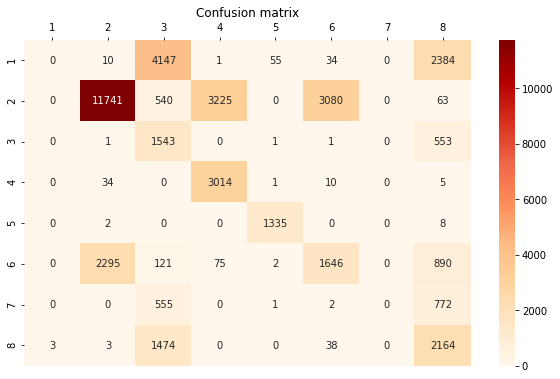

In [80]:
plot_confusion_matrix(gt_usefull, reconstruction_img_l_sk[reconstruction_img_l_sk != 0], class_names=np.arange(1, 9), log=False)

In [81]:
print(classification_report(gt_usefull, reconstruction_img_l_sk[reconstruction_img_l_sk != 0]))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00      6631
           2       0.83      0.63      0.72     18649
           3       0.18      0.74      0.29      2099
           4       0.48      0.98      0.64      3064
           5       0.96      0.99      0.97      1345
           6       0.34      0.33      0.33      5029
           7       0.00      0.00      0.00      1330
           8       0.32      0.59      0.41      3682

    accuracy                           0.51     41829
   macro avg       0.39      0.53      0.42     41829
weighted avg       0.52      0.51      0.49     41829



/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/guigux/Documents/env_ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [64]:
# Lasso - build image
reconstruction_l = E @ l_model.phi

reconstruction_img_l = np.zeros((Nrow * Ncol))
reconstruction_img_l[usefull_idx] = reconstruction_l[12]
reconstruction_img_l = reconstruction_img_l.reshape((Nrow, Ncol))

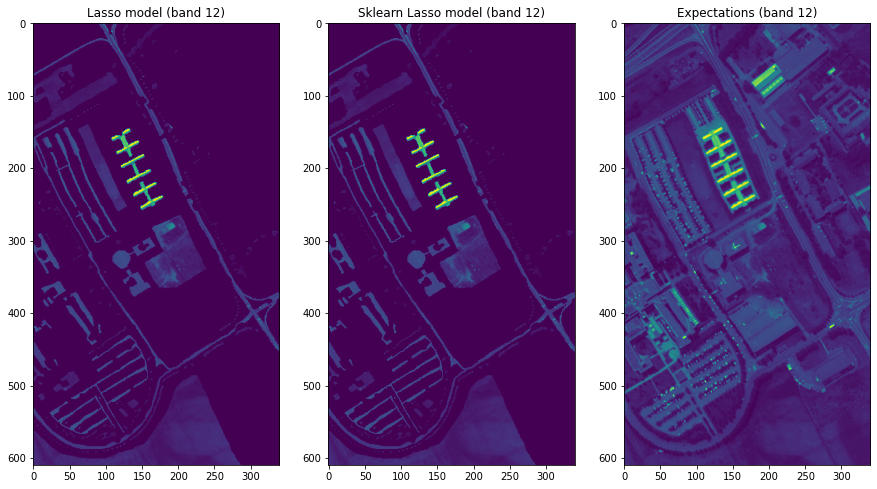

In [65]:
plt.figure(figsize=(15,10))

plt.subplot(1, 3, 1)
plt.title("Lasso model (band 12)")
plt.imshow(reconstruction_img_l)

plt.subplot(1, 3, 2)
plt.title("Sklearn Lasso model (band 12)")
plt.imshow(reconstruction_img_l_sk)

plt.subplot(1, 3, 3)
plt.title("Expectations (band 12)")
plt.imshow(hsi[:, :, 12])

plt.show()

En observant les deux images obtenus avec chacun des modèles de Lasso, on peut remarquer que les résultats sont très proches mais il serait plus judicieux de déterminer l'erreur moyenne entre ces résultats.

In [66]:
err = np.abs(reconstruction_img_l - reconstruction_img_l_sk)
print('Erreur moyenne: {}'.format(err.mean()))
print('Erreur maximale: {}'.format(err.max()))

Erreur moyenne: 0.0006422830308812745
Erreur maximale: 0.02102068548007041


Il semblerait que notre implémentation nous permet d'avoir des résultats similaires à ceux obtenus à partir du modèle de Sklearn. En effet, l'erreur moyenne est de 0.0006 (ordre de grandeur au millième) et l'erreur maximale est de 0.02.

In [67]:
coefs = np.zeros((Nrow * Ncol, 8))
coefs[usefull_idx] = lasso_sk.coef_
coefs = coefs.reshape((Nrow, Ncol, 8))

In [68]:
full_phi = np.zeros((Nrow * Ncol, 8))
full_phi[usefull_idx] = l_model.phi.T
full_phi = full_phi.reshape((Nrow, Ncol, 8))

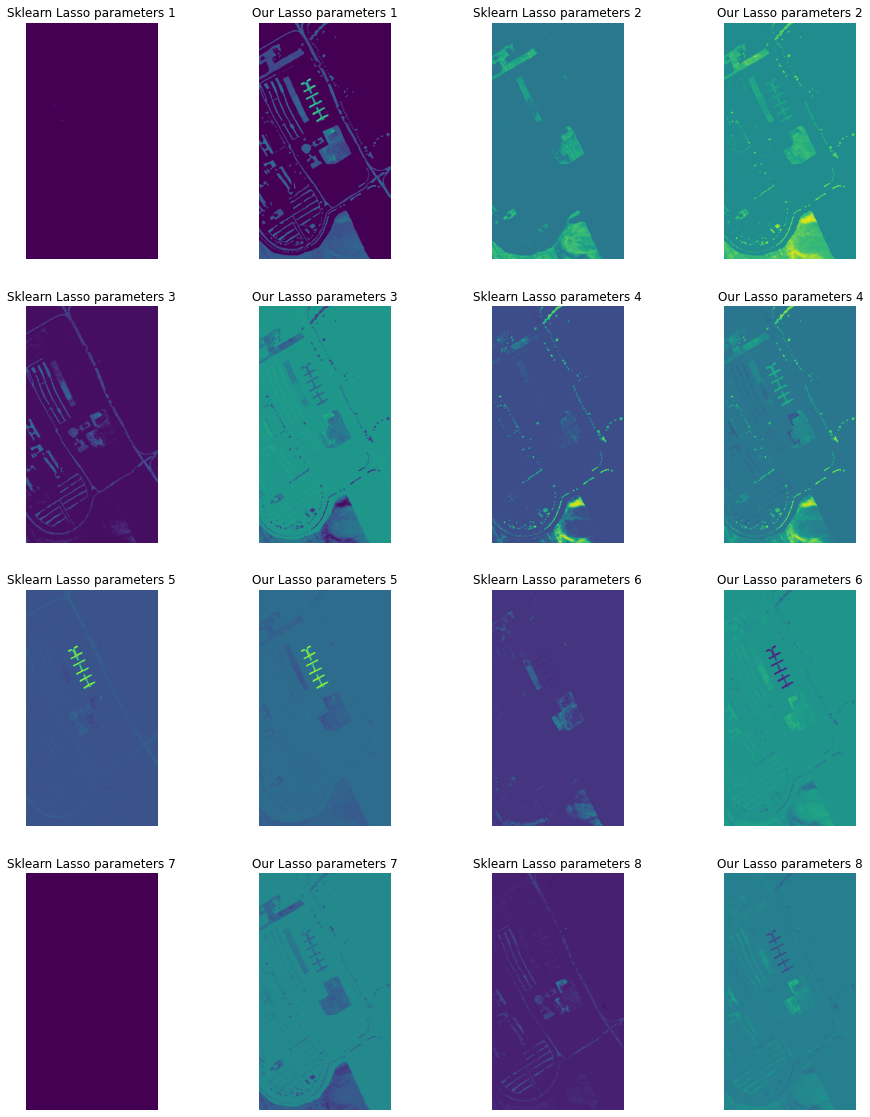

In [69]:
plt.figure(figsize=(16,20))

for i in range(8):
    plt.subplot(4, 4, 2 * i + 1)
    plt.title('Sklearn Lasso parameters {}'.format(i + 1))
    plt.imshow(coefs[:, :, i])
    plt.axis('off')
    
    plt.subplot(4, 4, 2 * i + 2)
    plt.title('Our Lasso parameters {}'.format(i + 1))
    plt.imshow(full_phi[:, :, i])
    plt.axis('off')
    
plt.show()

Nous pouvons remarquer que sur certaines cartes de l'implémentation Lasso de Sklearn, nous ne distinguons aucun motif (1, 3 et 7). Cependant, nous obtenons des resultats similaires pour les cartes 2, 4 et 5. \
Une fois de plus, nous pouvons noter que Sklearn Lasso n'est pas très efficace.

### Influence de $\lambda$

Pour déterminer l'influence de lambda, nous pouvons comparer la MSE de chaque modèle pour un même nombre d'itérations (ici 20). Notons que fixer un nombre d'itérations pour chaque modèle n'est pas optimale car il est possible que la MSE décroit très lentement.

In [70]:
l_model_lambda_0 = Lasso(lb=0.0005, num_iters=20)
mse_lambda_0 = l_model_lambda_0.fit(E, hsi_usefull.T, False)

In [71]:
l_model_lambda_0_5 = Lasso(lb=0.5, num_iters=20)
mse_lambda_0_5 = l_model_lambda_0_5.fit(E, hsi_usefull.T, False)

In [72]:
l_model_lambda_1 = Lasso(lb=1, num_iters=20)
mse_lambda_1 = l_model_lambda_1.fit(E, hsi_usefull.T, False)

In [73]:
l_model_lambda_5 = Lasso(lb=5, num_iters=20)
mse_lambda_5 = l_model_lambda_5.fit(E, hsi_usefull.T, False)

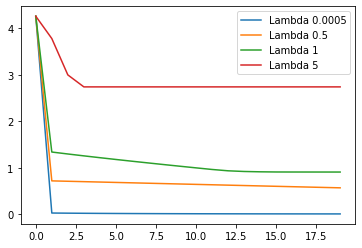

In [74]:
plt.plot(mse_lambda_0, label='Lambda 0.0005')
plt.plot(mse_lambda_0_5, label='Lambda 0.5')
plt.plot(mse_lambda_1, label='Lambda 1')
plt.plot(mse_lambda_5, label='Lambda 5')
plt.legend()
plt.show()

Nous pouvons constater que lorsque lambda augmente, la MSE décroit moins rapidement. Nous pouvons également noter que celui-ci semble converger vers une valeur non nulle lorsque lambda est trop grand. C'est notamment le cas lorsque lambda est à 5, la MSE est constante à partir de 3 itérations (nous affichons les valeurs qu'à 1e-5).

Il est préférable d'avoir un lambda petit.

### Comparaison entre les modèles

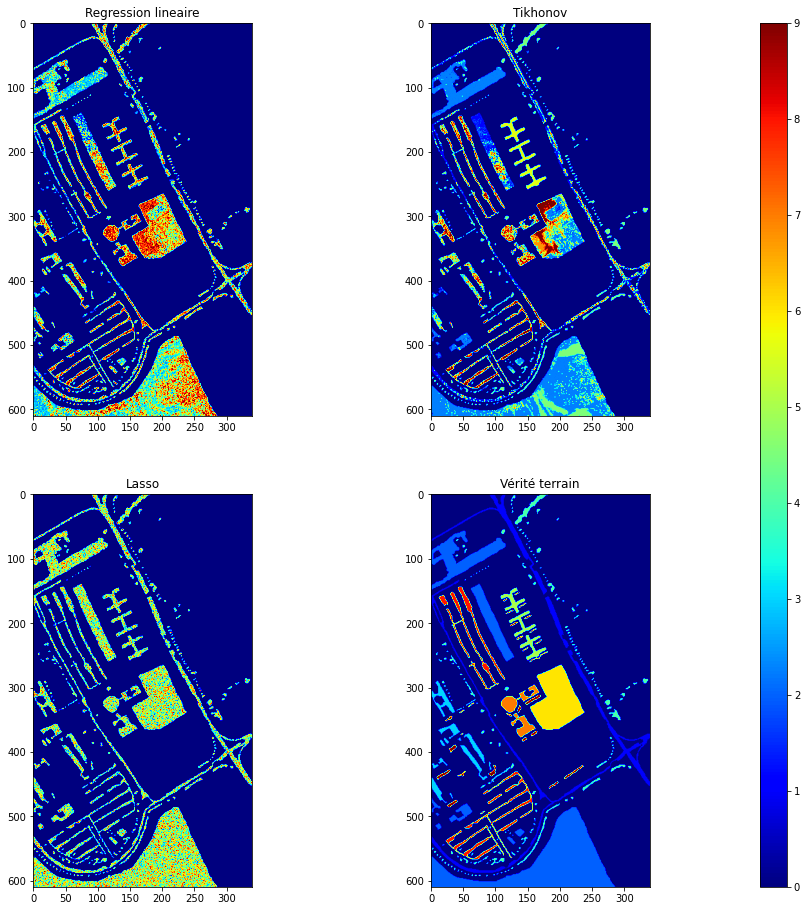

In [75]:
plt.figure(figsize=(15, 15))

plt.subplot(2, 2, 1)
plt.imshow(full_classifier, cmap='jet')
plt.title('Regression lineaire')

plt.subplot(2, 2, 2)
plt.imshow(full_classifier_tik, cmap='jet')
plt.title('Tikhonov')

plt.subplot(2, 2, 3)
plt.imshow(full_classifier_l, cmap='jet')
plt.title('Lasso')

plt.subplot(2, 2, 4)
plt.imshow(gt, cmap='jet')
plt.title('Vérité terrain')

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.85, 0.1, 0.025, 0.8])
plt.colorbar(imgt, cax=cax)

plt.show()

Nous aurions pu afficher les cartes d'abondances de chaque endmembers pour chaque modele mais cela ne nous permet pas d'avoir une idée globale de l'efficacité de chacun des modèle.\
Nous avons alors décidé de reconstruire les images pour chaque modèle et de les comparer avec la vérité terrain.

Comparaison Régression linéaire/moindres carrées et vérité terrain:\
Nous pouvons noter que pour chaque motif présent, il n'y a aucune couleur dominante dû au fait que la classification n'est pas efficace. Par exemple, pour la partie basse de l'image, les classes/couleurs présentes sont 4, 6, 7 et 8 alors que celle qui est attendue est 2. 

Comparaison Tikhonov et vérité terrain:\
La classification semble meilleure que celle de regression linéaire. En effet, certains motifs (x=50, y=100 et x=160, y=50) sont correctement classifiés malgré un peu de bruit. Nous pouvons également noter que sur la partie basse de l'image, la classification semble meilleure que la précédente (moins de bruits notamment).

Comparaison Lasso et vérité terrain:\
Comme nous pouvons le voir, la classification est mauvaise et le résultat obtenu est decevant. Chaque motif contient énormément de bruit et il est impossible de les classer.



**4.3) Explicitez les conclusions que vous pouvez en tirer, et quelle méthode de résolution vous paraît la plus favorable étant données notamment les contraintes physiques de positivité et de somme à un sur les abondances (qui ne sont pas prises en compte ici).**

Nous avons pu remarquer que la classification semble difficile sur nos données. Nous avons essayé plusieurs méthodes (moindres carrées, régularisation tikhonov, régularisation lasso) avec de légères modifications pour chacune et les résultats obtenus étaient très variables.

Les résultats obtenus avec Lasso étaient dans l'emsemble assez mauvais. En reconstruisant notre image, nous remarquons beaucoup de bruits sur les motifs apparents. Nous avons pu noter que la carte d'erreur de Lasso était très proche de celle de Tikhonov lambda=1.

Pour déterminer l'efficacité de la régularisation de Tikhonov, nous avons testé ce modèle avec des paramètres lambda différents. Nous avons pu noter que l'erreur quadratique moyenne était minimale lorsque lambda était proche de 0. La régularisation lasso nous donnait donc des résultats moins bon que ceux de Tikhonov avec un lambda inférieur à 1. (Nous avons également pu remarquer que la MSE est constante à partir d'un certain nombre d'itérations quand lambda est grand).

La méthode des moindres carrées nous permettait d'obtenir des valeurs de MSE très faible (ordre de grandeur au centième) mais lorsque nous reconstruisions l'image, nous avons pu observer des zones assez bruitées. En comparant cette méthode avec la régularisation de Tikhonov, nous remarquons qu'il s'agit de la seconde qui nous donne de meilleurs résultats. En effet, nous obtenons une précision de 0.28 avec la méthode des moindres carrées et une précision de plus de 0.60 avec la régularisation de Tikhonov.

En conclusion, les méthodes utilisées ne prennent pas en compte le fait que nous avons aucune contraintes. En effet, nous avons des valeurs d'abondance fractionnelle négatives alors qu'elles correspondent à des probabilités. De même, nous n'avons pas pris en compte le fait que la somme doit être égale à 1. Cependant, la meilleure méthode utilisée pour classifier est celle avec régularisation de Tikhonov (précision de +0.60).